# A360 Metadetection Shear

Contact author: Miranda Gorsuch

Create a shear profile for A360 using cell-based coadds and `metadetection`. Many parts are from the [Shear profile around A360 using ComCam HSM shapes](https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSCcalib_CLMM.ipynb) notebook, especially the identification of red sequence galaxies and use of CLMM to create the tangential shear plot.

Last working weekly: `w_2025_35`

Container Size: 16 GB (large)

# Preparing data

## Imports & Definitions

In [1]:
# locally install modeling packages (only do once, if not already installed)
# pip install pyccl
# pip install clmm

In [1]:
from lsst.daf.butler import Butler

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

import gc

from lsst.skymap import Index2D
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.geom as geom
import lsst.afw.display.rgb as afwRgb
import treecorr

# for stats control
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.meas.algorithms as meas

from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

from numpy.linalg import inv
import scipy.stats as stats
from scipy.stats import chi2, norm

import healsparse as hsp

import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)
h = 0.7
%matplotlib inline

# Position in degrees of the BCG for A360
ra_bcg = 37.865017
dec_bcg = 6.982205

REPO = '/sdf/data/rubin/repo/main/'
butler = Butler(REPO)
registry = butler.registry

In [31]:
meas_type = 'wmom'

if meas_type == 'wmom':
    collection = 'u/mgorsuch/metadetect/a360_3_band/noise/20250827T213552Z' # with S/N fix and correct noise correlations
elif meas_type == 'gauss':
    collection = 'u/mgorsuch/metadetect/a360_3_band_gauss/noise/20250827T214428Z' # with noise realizations
elif meas_type == 'pgauss':
    collection = 'u/mgorsuch/metadetect/a360_3_band_pgauss/noise/20250827T215647Z' # with noise realization
else:
    print("Not an available measurement type")

cell_collection = 'u/mgorsuch/ComCam_Cells/a360/corr_noise_cells/20250822T224002Z'

## Read in data

Metadetect outputs tables for each patch. Read in each table and compile them together.

In [32]:
datasetRefs_shear = []
overlap_patches_10463 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
tract_patch_list = [] # only used for plotting distribution of input images

for ref in butler.registry.queryDatasets('ShearObject', collections=collection):

    # the only parts of these tracts within 0.5 radius overlap with already included patches
    if ref.dataId['tract'] == 10704 or ref.dataId['tract'] == 10705:
        continue

    # these column of patches overlap with patches already in tract 10464
    if ref.dataId['tract'] == 10463 and ref.dataId['patch'] in overlap_patches_10463:
        continue
    
    datasetRefs_shear.append(butler.query_datasets('ShearObject', 
                                                     collections=collection,
                                                     skymap = 'lsst_cells_v1',
                                                     tract=ref.dataId['tract'],
                                                     patch=ref.dataId['patch']))

    tract_patch_list.append([ref.dataId['tract'], ref.dataId['patch']])

Combine the data from each patch into a single table.

In [33]:
shear_table_list = []

for i, ref in enumerate(datasetRefs_shear):
    shear_data_patch = butler.get(ref[0])
    shear_table_patch = shear_data_patch.to_pandas()
    shear_table_list.append(shear_table_patch)

shear_table = pd.concat(shear_table_list)

# remove unused tables to clear up memory
del shear_table_list
gc.collect()

11766

In [34]:
# save raw catalogs if desired
# if meas_type == 'wmom':
#     shear_table_wl.to_pickle("./md-raw-wmom.pkl")
# elif meas_type == 'gauss':
#     shear_table_wl.to_pickle("./md-raw-gauss.pkl")
# elif meas_type == 'pgauss':
#     shear_table_wl.to_pickle("./md-raw-pgauss.pkl")
# else:
#     print("Not an available measurement type")

### Remove duplicate objects from patch overlap

In [35]:
# copy table prior to duplicate removal for a later validation plot
shear_table_dup = shear_table.copy()

In [36]:
# remove objects in outer ring of cells in each patch since patch overlap is two cells
# TO-DO: exempt rows that don't overlap with other patches, e.g. patches on the edge of the field
shear_table = shear_table[shear_table['cell_x']!=0]
shear_table = shear_table[shear_table['cell_x']!=21]
shear_table = shear_table[shear_table['cell_y']!=0]
shear_table = shear_table[shear_table['cell_y']!=21]
print("Number of rows after removing most duplicate cells: ", len(shear_table))

# some additional tract/patch overlap appears to have a 4 cell overlap
filt1 = shear_table['tract'] == 10464
filt1 &= shear_table['patch_x'] == 9
filt1 &= shear_table['cell_x'] == 20
shear_table = shear_table[np.invert(filt1)]

filt2 = shear_table['tract'] == 10463
filt2 &= shear_table['patch_x'] == 1
filt2 &= shear_table['cell_x'] == 1
shear_table = shear_table[np.invert(filt2)]
print("Number of rows after removing patch overlap in 10464: ", len(shear_table))

Number of rows after removing most duplicate cells:  1161220
Number of rows after removing patch overlap in 10464:  1143571


In [37]:
# remove overlapping rows due to patch overlap    
print("Number of rows prior to removing duplicates: ", len(shear_table))
shear_table = shear_table.drop_duplicates(subset=['shear_type', 'ra', 'dec']) # each object will potentially have several sheared images
print("Number of rows after removing duplicates: ", len(shear_table))

Number of rows prior to removing duplicates:  1143571
Number of rows after removing duplicates:  1135268


### Add useful columns

In [38]:
# make new columns to convert nJy fluxes to AB magnitudes
t1 = Table.from_pandas(shear_table)

t1[f'{meas_type}_band_mag_g'] = (t1[f'{meas_type}_band_flux_g']*u.nJy).to(u.ABmag)
t1[f'{meas_type}_band_mag_r'] = (t1[f'{meas_type}_band_flux_r']*u.nJy).to(u.ABmag)
t1[f'{meas_type}_band_mag_i'] = (t1[f'{meas_type}_band_flux_i']*u.nJy).to(u.ABmag)
t1[f'{meas_type}_color_mag_g-r'] = t1[f'{meas_type}_band_mag_g']-t1[f'{meas_type}_band_mag_r']
t1[f'{meas_type}_color_mag_g-i'] = t1[f'{meas_type}_band_mag_g']-t1[f'{meas_type}_band_mag_i']
t1[f'{meas_type}_color_mag_r-i'] = t1[f'{meas_type}_band_mag_r']-t1[f'{meas_type}_band_mag_i']

shear_table = t1.to_pandas()

# Add columns for distance from BCG
c1 = SkyCoord(shear_table['ra'].values*u.deg, shear_table['dec'].values*u.deg)
c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
sep = c1.separation(c2)

shear_table['deg_sep'] = sep.value

shear_table['mpc_sep'] = cosmo.eval_da(0.22) * shear_table['deg_sep'] * np.pi/180

# uncertainties, flux errors are 1 standard deviation
shear_table[f'{meas_type}_mag_g_err'] = (2.5 / np.log(10)) * (shear_table[f'{meas_type}_band_flux_err_g'] / shear_table[f'{meas_type}_band_flux_g'])
shear_table[f'{meas_type}_mag_r_err'] = (2.5 / np.log(10)) * (shear_table[f'{meas_type}_band_flux_err_r'] / shear_table[f'{meas_type}_band_flux_r'])
shear_table[f'{meas_type}_mag_i_err'] = (2.5 / np.log(10)) * (shear_table[f'{meas_type}_band_flux_err_i'] / shear_table[f'{meas_type}_band_flux_i'])

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


## Apply `metadetect` flags

Anything that is flagged should be removed.

In [39]:
meta_filter = shear_table[f'{meas_type}_flags']==False
meta_filter &= shear_table['psfrec_flags']==False
meta_filter &= shear_table[f'{meas_type}_psf_flags']==False
meta_filter &= shear_table[f'{meas_type}_obj_flags']==False
meta_filter &= shear_table[f'{meas_type}_T_flags']==False
meta_filter &= shear_table[f'{meas_type}_band_flux_flags_r']==False
meta_filter &= shear_table[f'{meas_type}_band_flux_flags_i']==False

shear_table = shear_table[meta_filter]

print("Number of rows after removing metadetect flags: ", len(shear_table))
print("Number of rows in ns after removing metadetect flags: ", len(shear_table[shear_table['shear_type']=='ns']))

shear_table_md_cuts = shear_table.copy()

Number of rows after removing metadetect flags:  936518
Number of rows in ns after removing metadetect flags:  187377


## Identify and remove cluster member galaxies (all r axes)

Text(0.5, 0.98, 'Object Magnitudes')

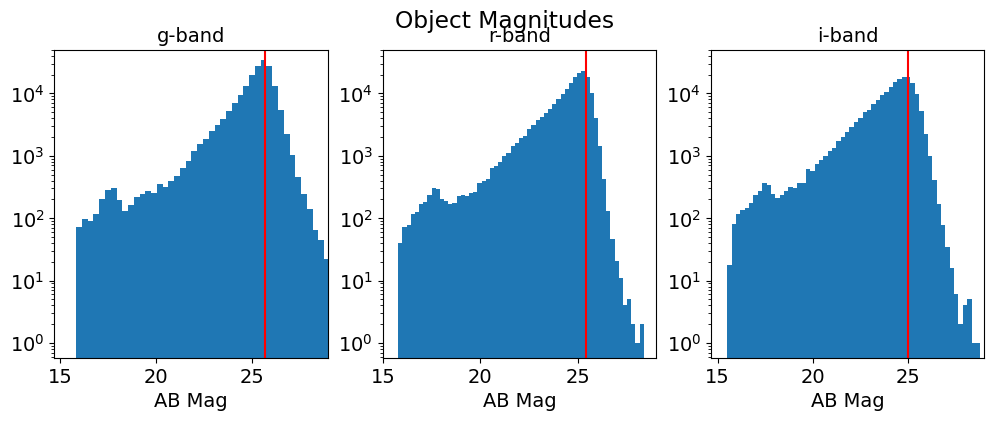

In [40]:
# isolate no shear catalog
shear_table_ns = shear_table[shear_table['shear_type']=='ns']

# pick plot parameters based on measurement type
if meas_type == 'wmom':
    g_line, r_line, i_line = 25.7, 25.4, 25.0
    ymax = 50000
elif meas_type == 'gauss':
    g_line, r_line, i_line = 24.6, 24.2, 23.8
    ymax = 50000
elif meas_type == 'pgauss':
    g_line, r_line, i_line = 24.8, 24.4, 24.0
    ymax = 50000
else:
    print("Not an available measurement type")

# distribution of magnitudes prior to cuts
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].hist(shear_table_ns[f'{meas_type}_band_mag_g'], bins=75)
ax[0].set_title("g-band")
ax[0].vlines(x=g_line, ymin=0, ymax=ymax, color='red')
ax[1].hist(shear_table_ns[f'{meas_type}_band_mag_r'], bins=75)
ax[1].set_title("r-band")
ax[1].vlines(x=r_line, ymin=0, ymax=ymax, color='red')
ax[2].hist(shear_table_ns[f'{meas_type}_band_mag_i'], bins=75)
ax[2].set_title("i-band")
ax[2].vlines(x=i_line, ymin=0, ymax=ymax, color='red')

for ax in ax.reshape(-1):
    ax.set_yscale('log')
    ax.set_xlabel("AB Mag")
    ax.set_xlim(right=29)
    ax.set_ylim(top=ymax)

plt.savefig(f'image_outputs_{meas_type}/object-magnitudes.png', bbox_inches='tight')
plt.suptitle("Object Magnitudes")

In [41]:
shear_table_wl = shear_table[shear_table['deg_sep'] < 0.5].copy() # catalog for WL measurements
print("Number of rows after applying < 0.5 deg from center: ", len(shear_table_wl))
print("Number of rows in ns after applying < 0.5 deg from center: ", len(shear_table_wl[shear_table_wl['shear_type']=='ns']))

Number of rows after applying < 0.5 deg from center:  572498
Number of rows in ns after applying < 0.5 deg from center:  114549


In [42]:
# plotting parameters
point_size = 0.6
point_alpha = 0.7

mag_lim = 24
bright_lim = 18

if meas_type == 'wmom':
    gi_range = (-0.09, 2.15, 1.85) # slope, upper range, lower range
    ri_range = (-0.03, 0.67, 0.47)
    gr_range = (-0.07, 1.53, 1.37)
elif meas_type == 'gauss':
    gi_range = (-0.06, 2.05, 1.75)
    ri_range = (-0.03, 0.63, 0.50)
    gr_range = (-0.04, 1.43, 1.25)
elif meas_type == 'pgauss':
    gi_range = (-0.08, 2.05, 1.85)
    ri_range = (-0.025, 0.62, 0.5)
    gr_range = (-0.05, 1.45, 1.28)
else:
    print("Not an available measurement type")

In [43]:
# Single cell RS removal

# ranges
gi_table_line_up = (shear_table_wl[f'{meas_type}_band_mag_r'] - 18) * (gi_range[0]) + gi_range[1]
ri_table_line_up = (shear_table_wl[f'{meas_type}_band_mag_r'] - 18) * (ri_range[0]) + ri_range[1]
gr_table_line_up = (shear_table_wl[f'{meas_type}_band_mag_r'] - 18) * (gr_range[0]) + gr_range[1]

gi_table_line_down = (shear_table_wl[f'{meas_type}_band_mag_r'] - 18) * (gi_range[0]) + gi_range[2]
ri_table_line_down = (shear_table_wl[f'{meas_type}_band_mag_r'] - 18) * (ri_range[0]) + ri_range[2]
gr_table_line_down = (shear_table_wl[f'{meas_type}_band_mag_r'] - 18) * (gr_range[0]) + gr_range[2]

gi_err = np.sqrt(shear_table_wl[f'{meas_type}_mag_g_err']**2 + shear_table_wl[f'{meas_type}_mag_i_err']**2)
ri_err = np.sqrt(shear_table_wl[f'{meas_type}_mag_r_err']**2 + shear_table_wl[f'{meas_type}_mag_i_err']**2)
gr_err = np.sqrt(shear_table_wl[f'{meas_type}_mag_g_err']**2 + shear_table_wl[f'{meas_type}_mag_r_err']**2)

gi_redseq = np.logical_and.reduce((shear_table_wl[f'{meas_type}_color_mag_g-i'] - gi_err < gi_table_line_up, 
                                   shear_table_wl[f'{meas_type}_color_mag_g-i'] + gi_err> gi_table_line_down,
                                   shear_table_wl[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_wl[f'{meas_type}_band_mag_r'] > bright_lim))

ri_redseq = np.logical_and.reduce((shear_table_wl[f'{meas_type}_color_mag_r-i'] - ri_err < ri_table_line_up, 
                                   shear_table_wl[f'{meas_type}_color_mag_r-i'] + ri_err > ri_table_line_down,
                                   shear_table_wl[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_wl[f'{meas_type}_band_mag_r'] > bright_lim))

gr_redseq = np.logical_and.reduce((shear_table_wl[f'{meas_type}_color_mag_g-r'] - gr_err < gr_table_line_up, 
                                   shear_table_wl[f'{meas_type}_color_mag_g-r'] + gr_err > gr_table_line_down,
                                   shear_table_wl[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_wl[f'{meas_type}_band_mag_r'] > bright_lim))

all_redseq = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))

# Filter out objects found in all_redseq
shear_table_wl = shear_table_wl[~all_redseq]
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type']=='ns']

print("Number of rows after 0.5 degree cut and RS cuts: ", len(shear_table_wl))
print("Number of rows after 0.5 degree cut and RS cuts, ns only: ", len(shear_table_wl_ns))

shear_table_rs_cuts = shear_table_wl.copy()

Number of rows after 0.5 degree cut and RS cuts:  553345
Number of rows after 0.5 degree cut and RS cuts, ns only:  110723


### Visual Inspection

In [16]:
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type'] == 'ns'].copy()
shear_table_rs = shear_table_wl[shear_table_wl['deg_sep'] < 0.1].copy()
shear_table_rs_ns = shear_table_rs[shear_table_rs['shear_type'] == 'ns']

#### Inner range of galaxies (< 0.1 Deg)

In [17]:
# ranges
gi_table_line_ns_up = (shear_table_rs_ns[f'{meas_type}_band_mag_r'] - 18) * (gi_range[0]) + gi_range[1]
ri_table_line_ns_up = (shear_table_rs_ns[f'{meas_type}_band_mag_r'] - 18) * (ri_range[0]) + ri_range[1]
gr_table_line_ns_up = (shear_table_rs_ns[f'{meas_type}_band_mag_r'] - 18) * (gr_range[0]) + gr_range[1]

gi_table_line_ns_down = (shear_table_rs_ns[f'{meas_type}_band_mag_r'] - 18) * (gi_range[0]) + gi_range[2]
ri_table_line_ns_down = (shear_table_rs_ns[f'{meas_type}_band_mag_r'] - 18) * (ri_range[0]) + ri_range[2]
gr_table_line_ns_down = (shear_table_rs_ns[f'{meas_type}_band_mag_r'] - 18) * (gr_range[0]) + gr_range[2]

gi_err = np.sqrt(shear_table_rs_ns[f'{meas_type}_mag_g_err']**2 + shear_table_rs_ns[f'{meas_type}_mag_i_err']**2)
ri_err = np.sqrt(shear_table_rs_ns[f'{meas_type}_mag_r_err']**2 + shear_table_rs_ns[f'{meas_type}_mag_i_err']**2)
gr_err = np.sqrt(shear_table_rs_ns[f'{meas_type}_mag_g_err']**2 + shear_table_rs_ns[f'{meas_type}_mag_r_err']**2)

gi_redseq = np.logical_and.reduce((shear_table_rs_ns[f'{meas_type}_color_mag_g-i'] - gi_err < gi_table_line_ns_up, 
                                   shear_table_rs_ns[f'{meas_type}_color_mag_g-i'] + gi_err > gi_table_line_ns_down,
                                   shear_table_rs_ns[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_rs_ns[f'{meas_type}_band_mag_r'] > bright_lim))

ri_redseq = np.logical_and.reduce((shear_table_rs_ns[f'{meas_type}_color_mag_r-i'] - ri_err < ri_table_line_ns_up, 
                                   shear_table_rs_ns[f'{meas_type}_color_mag_r-i'] + ri_err > ri_table_line_ns_down,
                                   shear_table_rs_ns[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_rs_ns[f'{meas_type}_band_mag_r'] > bright_lim))

gr_redseq = np.logical_and.reduce((shear_table_rs_ns[f'{meas_type}_color_mag_g-r'] - gr_err < gr_table_line_ns_up, 
                                   shear_table_rs_ns[f'{meas_type}_color_mag_g-r'] + gr_err > gr_table_line_ns_down,
                                   shear_table_rs_ns[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_rs_ns[f'{meas_type}_band_mag_r'] > bright_lim))

all_redseq = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))

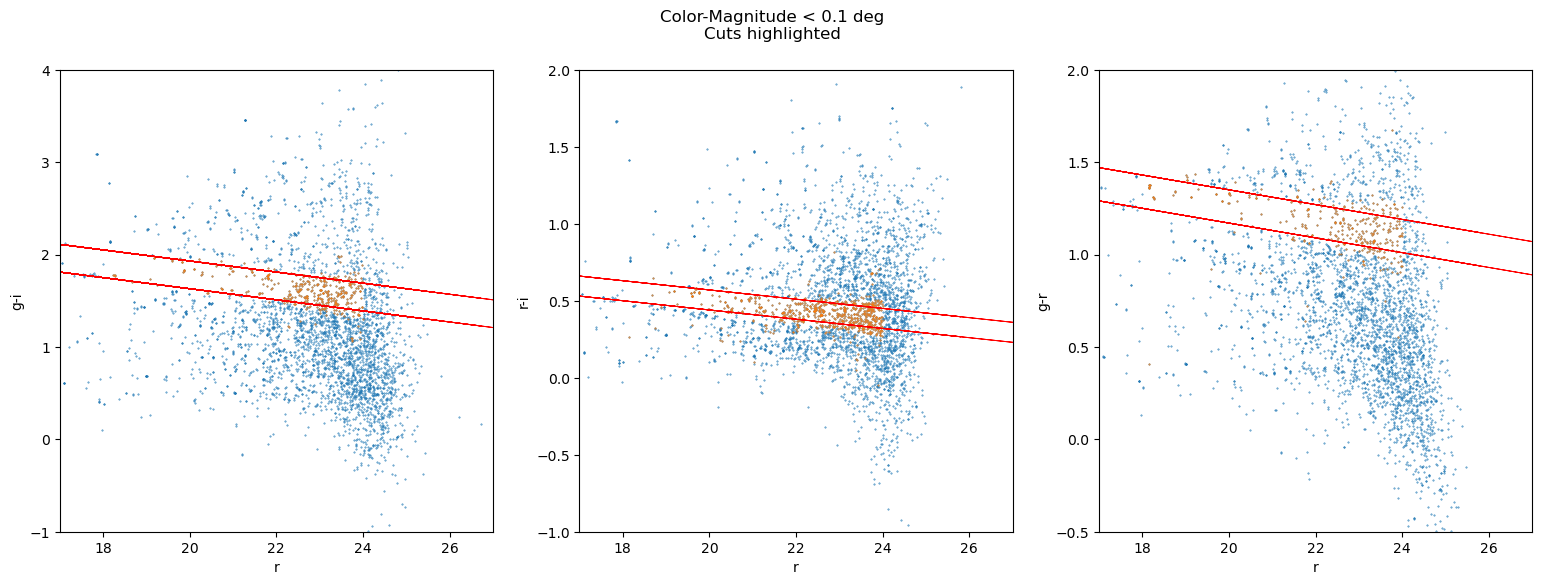

In [18]:
fig, axes = plt.subplots(1,3, figsize=(19, 6))

axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][gi_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-i'][gi_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_up, color='r', linewidth=0.7)
axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_down, color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][ri_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_r-i'][ri_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_up, color='r', linewidth=0.7)
axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_down, color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][gr_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-r'][gr_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_up, color='r', linewidth=0.7)
axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_down, color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.1 deg\nCuts highlighted")
plt.show()

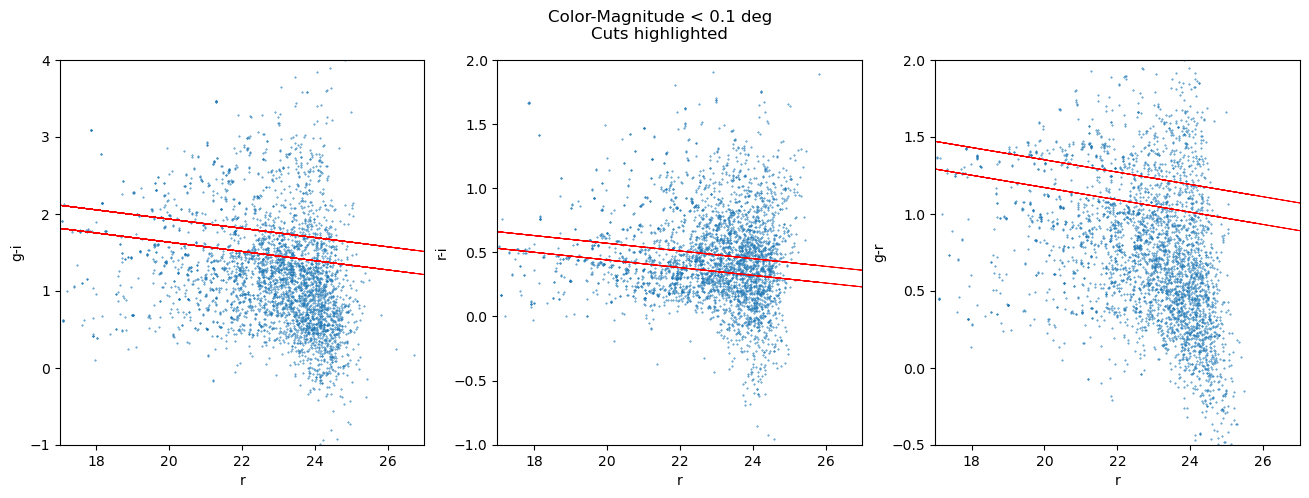

In [19]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_up, color='r', linewidth=0.7)
axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_down, color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_r-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_up, color='r', linewidth=0.7)
axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_down, color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-r'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_up, color='r', linewidth=0.7)
axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_down, color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.1 deg\nCuts highlighted")
plt.show()

#### Most galaxies (< 0.5 Deg)

In [20]:
# ranges
gi_table_line_ns_up = (shear_table_wl_ns[f'{meas_type}_band_mag_r'] - 18) * (gi_range[0]) + gi_range[1]
ri_table_line_ns_up = (shear_table_wl_ns[f'{meas_type}_band_mag_r'] - 18) * (ri_range[0]) + ri_range[1]
gr_table_line_ns_up = (shear_table_wl_ns[f'{meas_type}_band_mag_r'] - 18) * (gr_range[0]) + gr_range[1]

gi_table_line_ns_down = (shear_table_wl_ns[f'{meas_type}_band_mag_r'] - 18) * (gi_range[0]) + gi_range[2]
ri_table_line_ns_down = (shear_table_wl_ns[f'{meas_type}_band_mag_r'] - 18) * (ri_range[0]) + ri_range[2]
gr_table_line_ns_down = (shear_table_wl_ns[f'{meas_type}_band_mag_r'] - 18) * (gr_range[0]) + gr_range[2]

gi_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_mag_g_err']**2 + shear_table_wl_ns[f'{meas_type}_mag_i_err']**2)
ri_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_mag_r_err']**2 + shear_table_wl_ns[f'{meas_type}_mag_i_err']**2)
gr_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_mag_g_err']**2 + shear_table_wl_ns[f'{meas_type}_mag_r_err']**2)

gi_redseq = np.logical_and.reduce((shear_table_wl_ns[f'{meas_type}_color_mag_g-i'] - gi_err < gi_table_line_ns_up, 
                                   shear_table_wl_ns[f'{meas_type}_color_mag_g-i'] + gi_err > gi_table_line_ns_down,
                                   shear_table_wl_ns[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_wl_ns[f'{meas_type}_band_mag_r'] > bright_lim))

ri_redseq = np.logical_and.reduce((shear_table_wl_ns[f'{meas_type}_color_mag_r-i'] - ri_err < ri_table_line_ns_up, 
                                   shear_table_wl_ns[f'{meas_type}_color_mag_r-i'] + ri_err > ri_table_line_ns_down,
                                   shear_table_wl_ns[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_wl_ns[f'{meas_type}_band_mag_r'] > bright_lim))

gr_redseq = np.logical_and.reduce((shear_table_wl_ns[f'{meas_type}_color_mag_g-r'] - gr_err < gr_table_line_ns_up, 
                                   shear_table_wl_ns[f'{meas_type}_color_mag_g-r'] + gr_err> gr_table_line_ns_down,
                                   shear_table_wl_ns[f'{meas_type}_band_mag_r'] < mag_lim, 
                                   shear_table_wl_ns[f'{meas_type}_band_mag_r'] > bright_lim))

all_redseq = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))

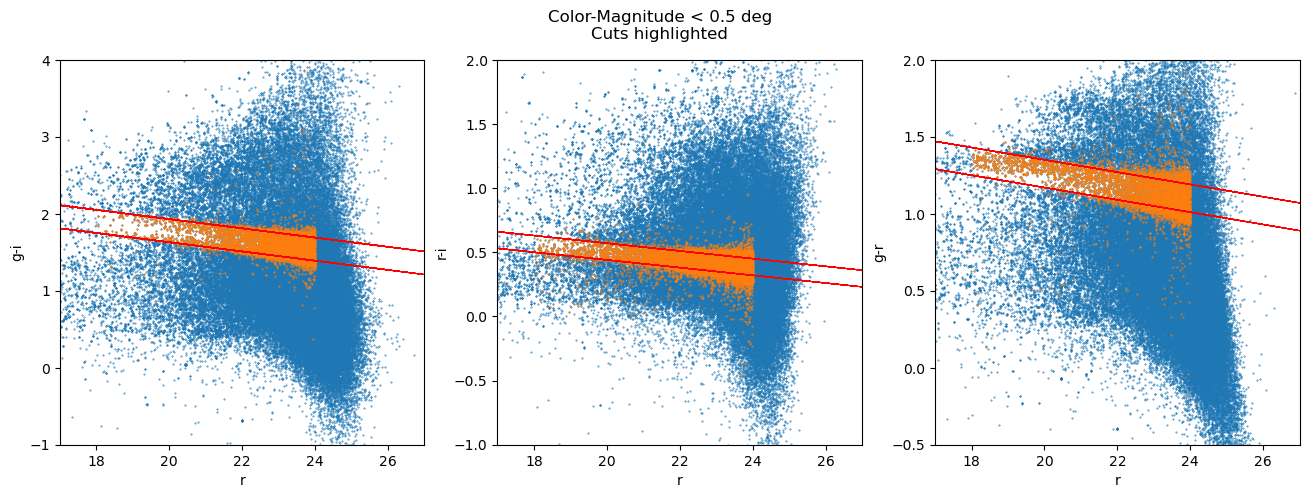

In [21]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][gi_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-i'][gi_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_up, color='r', linewidth=0.7)
axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_down, color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][ri_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_r-i'][ri_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_up, color='r', linewidth=0.7)
axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_down, color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][gr_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-r'][gr_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_up, color='r', linewidth=0.7)
axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_down, color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.5 deg\nCuts highlighted")
plt.show()

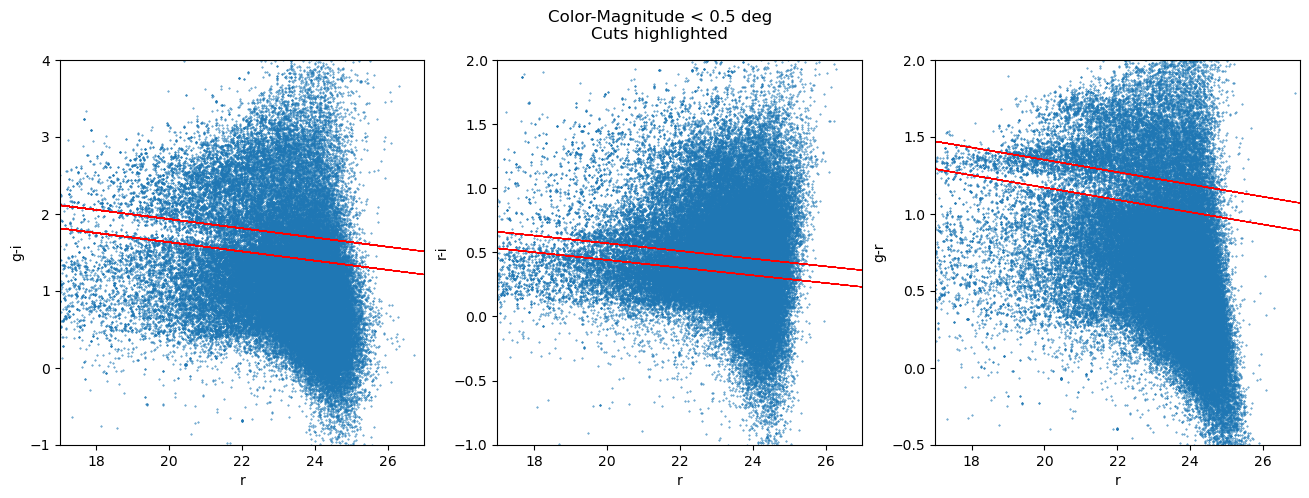

In [22]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_up, color='r', linewidth=0.7)
axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_down, color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_r-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_up, color='r', linewidth=0.7)
axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_down, color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-r'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_up, color='r', linewidth=0.7)
axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_down, color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.5 deg\nCuts highlighted")
plt.show()

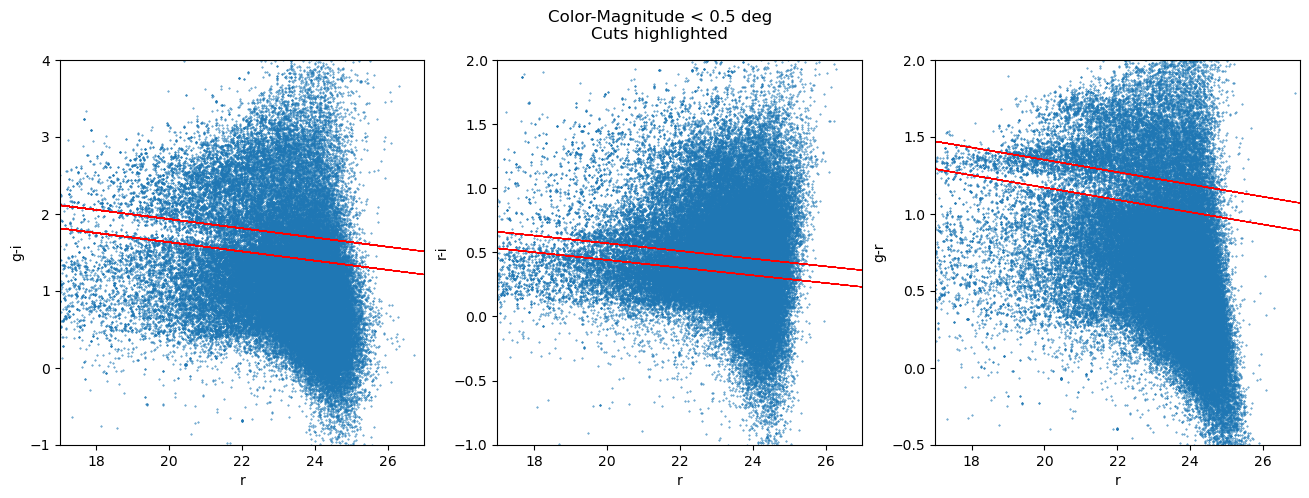

In [23]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))

axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_up, color='r', linewidth=0.7)
axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gi_table_line_ns_down, color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_up, color='r', linewidth=0.7)
axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], ri_table_line_ns_down, color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_up, color='r', linewidth=0.7)
axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], gr_table_line_ns_down, color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.5 deg\nCuts highlighted")
plt.show()

## Apply masks as done in mask technote

For example notebook, see [here](https://github.com/lsst-sitcom/comcam_clusters/blob/main/A360_masking_example.ipynb)

In [44]:
mask_hsp = hsp.HealSparseMap.read('/home/b/bclevine/A360/A360_full_mask_hsp_128_131072.parquet')

# mask = ~mask_hsp['full_mask'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True)
star_mask = ~mask_hsp['bo'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True) # bright objects
dust_mask = ~mask_hsp['sfd'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True) # masks from SFD dust map
hand_mask = ~mask_hsp['hand'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True)  # masks done by hand, e.g. galactic cirrus
# exp_mask = ~mask_hsp['exp'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True) # edge / num exp mask

mask = star_mask & dust_mask & hand_mask

print("Number of rows in ns before mask applied: ", len(shear_table_wl[shear_table_wl['shear_type']=='ns']))
shear_table_wl = shear_table_wl[mask]
print("Number of rows in ns after mask applied : ", len(shear_table_wl[shear_table_wl['shear_type']=='ns']))

shear_table_masked = shear_table_wl.copy()

Number of rows in ns before mask applied:  110723
Number of rows in ns after mask applied :  87324


## Quality cuts

Some cuts based on [Yamamoto 2024](https://arxiv.org/abs/2501.05665) (such as T_ratio and color-color cuts)

In [45]:
def print_rows_removed(og_table, meas_type):
    total = len(og_table)

    if meas_type == 'wmom':
        print(f"{meas_type}_T_ratio rows removed: ", total-len(og_table[og_table[f'{meas_type}_T_ratio']>1.1]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_T_ratio']>1.1]) / total))
        print(f"{meas_type}_band_mag_i rows removed: ", total-len(og_table[og_table[f'{meas_type}_band_mag_i']<=24.0]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_band_mag_i']<=24.0]) / total))
    elif meas_type == 'gauss':
        print(f"{meas_type}_T_ratio rows removed: ", total-len(og_table[og_table[f'{meas_type}_T_ratio']>0.3]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_T_ratio']>0.3]) / total))
        print(f"{meas_type}_band_mag_i rows removed: ", total-len(og_table[og_table[f'{meas_type}_band_mag_i']<=23.5]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_band_mag_i']<=23.5]) / total))
    elif meas_type == 'pgauss':
        print(f"{meas_type}_T_ratio rows removed: ", total-len(og_table[og_table[f'{meas_type}_T_ratio']>0.3]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_T_ratio']>0.3]) / total))
        print(f"{meas_type}_band_mag_i rows removed: ", total-len(og_table[og_table[f'{meas_type}_band_mag_i']<=23.75]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_band_mag_i']<=23.75]) / total))
    else:
        print("Not an available measurement type")
    
    print(f"{meas_type}_T_ratio rows removed: ", total-len(og_table[og_table[f'{meas_type}_T_ratio']>1.1]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_T_ratio']>1.1]) / total))
    print(f"{meas_type}_s2n rows removed: ", total-len(og_table[og_table[f'{meas_type}_s2n']>10]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_s2n']>10]) / total))
    print(f"{meas_type}_T rows removed: ", total-len(og_table[og_table[f'{meas_type}_T']<20]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_T']<20]) / total))
    print("m_frac rows removed: ", total-len(og_table[og_table['mfrac']<0.1]), "  (", \
        (1 - len(og_table[og_table['mfrac']<0.1]) / total))
    print(f"{meas_type}_band_mag_i rows removed: ", total-len(og_table[og_table[f'{meas_type}_band_mag_i']<=24.0]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_band_mag_i']<=24.0]) / total))
    print(f"{meas_type}_color_mag_g-r rows removed: ", total-len(og_table[(og_table[f'{meas_type}_color_mag_g-r']).abs()<5]), "  (", \
        (1 - len(og_table[(og_table[f'{meas_type}_color_mag_g-r']).abs()<5]) / total))
    print(f"{meas_type}_color_mag_r-i rows removed: ", total-len(og_table[(og_table[f'{meas_type}_color_mag_r-i']).abs()<5]), "  (", \
        (1 - len(og_table[(og_table[f'{meas_type}_color_mag_r-i']).abs()<5]) / total))
    print(f"{meas_type}_color_mag_r-i rows removed: ", total-len(og_table[(og_table[f'{meas_type}_color_mag_g-i']).abs()<5]), "  (", \
        (1 - len(og_table[(og_table[f'{meas_type}_color_mag_g-i']).abs()<5]) / total))
    print(f"{meas_type}_band_mag_i<20 rows removed: ", total-len(og_table[og_table[f'{meas_type}_band_mag_i']>20]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_band_mag_i']>20]) / total))

In [46]:
# cuts determined mainly from Yamamoto but also additional analyses here
final_cuts = shear_table_wl[f'{meas_type}_s2n']>10
final_cuts &= shear_table_wl[f'{meas_type}_T']<20
final_cuts &= shear_table_wl['mfrac']<0.1
final_cuts &= (shear_table_wl[f'{meas_type}_color_mag_g-r']).abs()<5
final_cuts &= (shear_table_wl[f'{meas_type}_color_mag_r-i']).abs()<5
final_cuts &= (shear_table_wl[f'{meas_type}_color_mag_g-i']).abs()<5
final_cuts &= shear_table_wl[f'{meas_type}_band_mag_i']>20

if meas_type == 'wmom':
    final_cuts &= shear_table[f'{meas_type}_T_ratio']>1.1
    final_cuts &= shear_table_wl[f'{meas_type}_band_mag_i']<=24.0
elif meas_type == 'gauss':
    final_cuts &= shear_table[f'{meas_type}_T_ratio']>0.3
    final_cuts &= shear_table_wl[f'{meas_type}_band_mag_i']<=23.5
elif meas_type == 'pgauss':
    final_cuts &= shear_table[f'{meas_type}_T_ratio']>0.3
    final_cuts &= shear_table_wl[f'{meas_type}_band_mag_i']<=23.75
else:
    print("Not an available measurement type")

print(len(shear_table_wl))
print_rows_removed(shear_table_wl, meas_type)

shear_table_wl = shear_table_wl[final_cuts]
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type']=='ns']

print()
print("Number of rows after applying quality cuts: ", len(shear_table_wl))
print("Number of rows in ns after applying quality cuts: ", len(shear_table_wl_ns))

436493
wmom_T_ratio rows removed:  188010   ( 0.43072855692989354
wmom_band_mag_i rows removed:  286277   ( 0.6558570240530777
wmom_T_ratio rows removed:  188010   ( 0.43072855692989354
wmom_s2n rows removed:  112328   ( 0.2573420421404238
wmom_T rows removed:  0   ( 0.0
m_frac rows removed:  0   ( 0.0
wmom_band_mag_i rows removed:  286277   ( 0.6558570240530777
wmom_color_mag_g-r rows removed:  1611   ( 0.0036907808372642625
wmom_color_mag_r-i rows removed:  149   ( 0.0003413571351659206
wmom_color_mag_r-i rows removed:  1771   ( 0.004057338834757895
wmom_band_mag_i<20 rows removed:  6857   ( 0.01570930118008762

Number of rows after applying quality cuts:  93044
Number of rows in ns after applying quality cuts:  18605


In [29]:
# save the final sample
if meas_type == 'wmom':
    shear_table_wl.to_pickle("./md-wl-wmom.pkl")
elif meas_type == 'gauss':
    shear_table_wl.to_pickle("./md-wl-gauss.pkl")
elif meas_type == 'pgauss':
    shear_table_wl.to_pickle("./md-wl-pgauss.pkl")
else:
    print("Not an available measurement type")

# Looking at shear outputs

## Check shear types for each object

Each object is detected and measured separately for each sheared/unsheared image. The catalogs will not necessarily be the same but should be close in number of objects.

In [47]:
# split catalog by shear type
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type']=='ns']
shear_table_wl_1p = shear_table_wl[shear_table_wl['shear_type']=='1p']
shear_table_wl_1m = shear_table_wl[shear_table_wl['shear_type']=='1m']
shear_table_wl_2p = shear_table_wl[shear_table_wl['shear_type']=='2p']
shear_table_wl_2m = shear_table_wl[shear_table_wl['shear_type']=='2m']

In [48]:
print("Number of shear type 'ns': ", len(shear_table_wl_ns))
print("Number of shear type '1p': ", len(shear_table_wl_1p))
print("Number of shear type '1m': ", len(shear_table_wl_1m))
print("Number of shear type '2p': ", len(shear_table_wl_2p))
print("Number of shear type '2m': ", len(shear_table_wl_2m))

Number of shear type 'ns':  18605
Number of shear type '1p':  18631
Number of shear type '1m':  18588
Number of shear type '2p':  18602
Number of shear type '2m':  18618


## Determining tangential & cross shear

In [49]:
shear_diff = 0.02

# bins_mpc = clmm.make_bins(0.5,6,nbins=7, method='evenlog10width')
bins_mpc = clmm.make_bins((0.5/h), (3.2/(h*(1+0.22))), nbins=5, method='evenlog10width')

### Global R

In [79]:
p1_mean = shear_table_wl_1p[f'{meas_type}_g_1'].mean()
m1_mean = shear_table_wl_1m[f'{meas_type}_g_1'].mean()
p2_mean = shear_table_wl_2p[f'{meas_type}_g_2'].mean()
m2_mean = shear_table_wl_2m[f'{meas_type}_g_2'].mean()

r_matrix = [[0, 0],[0, 0]]

r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff
# r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore?
# r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff
r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff

r_matrix_inv = inv(r_matrix)

# calculate R error
p1_err = np.std(shear_table_wl_1p[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1p[f'{meas_type}_g_1']))
m1_err = np.std(shear_table_wl_1m[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1m[f'{meas_type}_g_1']))
p2_err = np.std(shear_table_wl_2p[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2p[f'{meas_type}_g_2']))
m2_err = np.std(shear_table_wl_2m[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2m[f'{meas_type}_g_2']))

r11_err = np.sqrt(p1_err**2 + m1_err**2)
r22_err = np.sqrt(p2_err**2 + m2_err**2)

print("R11, R22: ", r_matrix[0][0], r_matrix[1][1])
print("R11_err, R22_err: ", r11_err, r22_err)
print("Difference of R11 and R22: ", np.abs(r_matrix[0][0]-r_matrix[1][1]))

R11, R22:  0.20132584031671286 0.18653017468750477
R11_err, R22_err:  0.0005877852795891561 0.0006110601006547575
Difference of R11 and R22:  0.014795665629208088


In [80]:
# apply R to each g1/g2 pair
g1_cal, g2_cal = r_matrix_inv.dot([shear_table_wl_ns[f'{meas_type}_g_1'], shear_table_wl_ns[f'{meas_type}_g_2']])

#### Creating a GC Object

In [81]:
# get shape uncertainties from covariance matrix
g1_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_11'])
g2_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_22'])
g_err = np.mean([np.array(g1_err.values), np.array(g2_err.values)], axis=0)

In [82]:
galcat = GCData()
galcat['ra'] = shear_table_wl_ns['ra']
galcat['dec'] = shear_table_wl_ns['dec']
galcat['e1'] = g1_cal
galcat['e2'] = g2_cal
galcat['e_err'] = g_err/2 # factor of 2 to convert from g to e
# galcat['hsm_weight'] = weight
galcat['id'] = np.arange(len(shear_table_wl_ns))
galcat['z'] = np.zeros(len(shear_table_wl_ns))
# galcat['z'] = wl_table['fzb_z_median']
    
cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')

gc_object1.compute_tangential_and_cross_components(add=True);

gc_object1.compute_galaxy_weights(
        shape_component1="e1",
        shape_component2="e2",
        use_shape_error=True,
        shape_component1_err="e_err",
        shape_component2_err="e_err",
        use_shape_noise=True,
        weight_name="w_ls",
        cosmo=cosmo,
        add=True,
    )

gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=False, gal_ids_in_bins=False);

gc_object1.save(f'./profile_metadetect_{meas_type}')

In [83]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(3.5)
moo.set_mass(4.e14)

z_cl = gc_object1.z

# source properties
# Wrongly assume sources redshift following a the DESC SRD distribution (pre-coded in CLMM). 
# Just to get something in the ballpark of what to expect

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.1),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

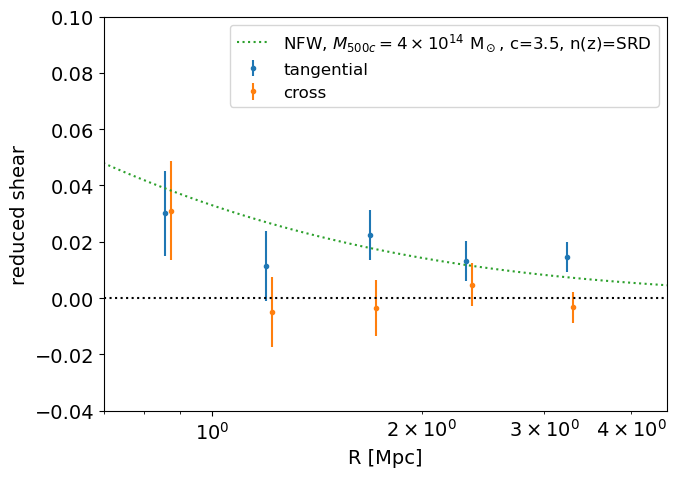

In [84]:
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

ax.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label='tangential')
ax.errorbar(gc_object1.profile['radius']*1.02, gc_object1.profile['gx'], gc_object1.profile['gx_err'], 
             ls='', marker='.', label='cross')
ax.plot(rproj, gt_z, label=r'NFW, $M_{500c}=4 \times 10^{14}$ M$_\odot$, c=3.5, n(z)=SRD', ls=':')

ax.set_xscale('log')
ax.axhline(0.0, color='k', ls=':')
ax.set_ylim([-0.04,0.1])
ax.set_xlim([0.7,4.5])
# ax.set_xlim([0.5,4.5])
ax.set_xlabel('R [Mpc]')
#plt.xlabel('separation [deg]')
ax.set_ylabel('reduced shear')
ax.legend(loc=1, fontsize=12)
fig.tight_layout()
fig.savefig(f'image_outputs_{meas_type}/shear_profile.png')

Calculate significance of the shear signal

Originally from https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSM_HSCcalib_CLMM_forTN.ipynb

In [85]:
gamma_t = gc_object1.profile['gt']
sigma_t = gc_object1.profile['gt_err']
gamma_x = gc_object1.profile['gx']
sigma_x = gc_object1.profile['gx_err']

# Compute chi-squared statistic (compared to null hypothesis)
chi2_stat_t = np.sum((gamma_t / sigma_t)**2)
chi2_stat_x = np.sum((gamma_x / sigma_x)**2)
dof = len(gamma_t)

# Compute p-value from chi-squared distribution
p_value_t = 1 - chi2.cdf(chi2_stat_t, dof)
p_value_x = 1 - chi2.cdf(chi2_stat_x, dof)

# Convert p-value to significance in sigma
significance_sigma_t = norm.isf(p_value_t)  # isf = inverse survival function (1 - CDF)
significance_sigma_x = norm.isf(p_value_x)  # isf = inverse survival function (1 - CDF)

# Print results
print("Tangential signal")
print(f"Chi-squared statistic: {chi2_stat_t:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value_t:.4e}")
print(f"Detection significance: {significance_sigma_t:.2f} sigma")
print("\nCross signal")
print(f"Chi-squared statistic: {chi2_stat_x:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value_x:.4e}")
print(f"Detection significance: {significance_sigma_x:.2f} sigma")

Tangential signal
Chi-squared statistic: 21.547
Degrees of freedom: 5
p-value: 6.3826e-04
Detection significance: 3.22 sigma

Cross signal
Chi-squared statistic: 4.131
Degrees of freedom: 5
p-value: 5.3076e-01
Detection significance: -0.08 sigma


### Radial Bin R

- Calculate $R_i$ for each bin
- Calibrate individual $g_1,g_2$ for the GC object (able to customize bins later through the GC object)
    - Need to also redo calibrated errors...
- Calibrate mean $g_t/g_x$ in each bin to compare against GC object

In [65]:
dig_mpc_bins_ns = np.digitize(shear_table_wl_ns['mpc_sep'], bins_mpc)
dig_mpc_bins_1p = np.digitize(shear_table_wl_1p['mpc_sep'], bins_mpc)
dig_mpc_bins_1m = np.digitize(shear_table_wl_1m['mpc_sep'], bins_mpc)
dig_mpc_bins_2p = np.digitize(shear_table_wl_2p['mpc_sep'], bins_mpc)
dig_mpc_bins_2m = np.digitize(shear_table_wl_2m['mpc_sep'], bins_mpc)

In [66]:
shear_table_wl_ns = shear_table_wl_ns.copy()
shear_table_wl_ns['g1_cal'] = 0.0
shear_table_wl_ns['g2_cal'] = 0.0

for i in range(0, len(bins_mpc)-1):
    bin_filt_ns = dig_mpc_bins_ns == i+1

    # print number of galaxies in each bin
    print("Rows in bin ", i, " :", len(shear_table_wl_ns['g1_cal'][bin_filt_ns]))

    # calculate mean g1/g2 for each shear type
    bin_filt_1p = dig_mpc_bins_1p == i+1
    bin_filt_1m = dig_mpc_bins_1m == i+1
    bin_filt_2p = dig_mpc_bins_2p == i+1
    bin_filt_2m = dig_mpc_bins_2m == i+1
    
    p1_mean = shear_table_wl_1p[f'{meas_type}_g_1'][bin_filt_1p].mean()
    m1_mean = shear_table_wl_1m[f'{meas_type}_g_1'][bin_filt_1m].mean()
    p2_mean = shear_table_wl_2p[f'{meas_type}_g_2'][bin_filt_2p].mean()
    m2_mean = shear_table_wl_2m[f'{meas_type}_g_2'][bin_filt_2m].mean()

    # calculate R and relevant quantities for this bin
    r_matrix = [[0, 0],[0, 0]]

    r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff
    # r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore?
    # r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff
    r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff
    
    r_matrix_inv = inv(r_matrix)
    
    # # calculate R error
    p1_err = np.std(shear_table_wl_1p[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1p[f'{meas_type}_g_1']))
    m1_err = np.std(shear_table_wl_1m[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1m[f'{meas_type}_g_1']))
    p2_err = np.std(shear_table_wl_2p[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2p[f'{meas_type}_g_2']))
    m2_err = np.std(shear_table_wl_2m[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2m[f'{meas_type}_g_2']))
    
    r11_err = np.sqrt(p1_err**2 + m1_err**2)
    r22_err = np.sqrt(p2_err**2 + m2_err**2)
    
    print("R11, R22: ", r_matrix[0][0], r_matrix[1][1])
    print("R11_err, R22_err: ", r11_err, r22_err)
    print("Difference of R11 and R22: ", np.abs(r_matrix[0][0]-r_matrix[1][1]))
    print()

    # apply R to each g1/g2 pair
    g1_cal, g2_cal = r_matrix_inv.dot([shear_table_wl_ns[f'{meas_type}_g_1'][bin_filt_ns], shear_table_wl_ns[f'{meas_type}_g_2'][bin_filt_ns]])

    # save calibrated shears in catalog
    shear_table_wl_ns.loc[bin_filt_ns, 'g1_cal'] = g1_cal
    shear_table_wl_ns.loc[bin_filt_ns, 'g2_cal'] = g2_cal

Rows in bin  0  : 269
R11, R22:  0.23009437136352062 0.17730763647705317
R11_err, R22_err:  0.0005877852795891561 0.0006110601006547575
Difference of R11 and R22:  0.05278673488646746

Rows in bin  1  : 503
R11, R22:  0.22133493330329657 0.1710575888864696
R11_err, R22_err:  0.0005877852795891561 0.0006110601006547575
Difference of R11 and R22:  0.05027734441682696

Rows in bin  2  : 973
R11, R22:  0.18697812920436263 0.10935437167063355
R11_err, R22_err:  0.0005877852795891561 0.0006110601006547575
Difference of R11 and R22:  0.07762375753372908

Rows in bin  3  : 1651
R11, R22:  0.18872247310355306 0.20021428354084492
R11_err, R22_err:  0.0005877852795891561 0.0006110601006547575
Difference of R11 and R22:  0.01149181043729186

Rows in bin  4  : 3087
R11, R22:  0.21993066184222698 0.16954329330474138
R11_err, R22_err:  0.0005877852795891561 0.0006110601006547575
Difference of R11 and R22:  0.0503873685374856



#### Create a GC Object

In [67]:
# get shape uncertainties from covariance matrix
g1_err_rad = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_11'])
g2_err_rad = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_22'])
g_err_rad = np.mean([np.array(g1_err_rad.values), np.array(g2_err_rad.values)], axis=0) # TO-DO do proper error propagation

In [68]:
galcat_rad = GCData()
galcat_rad['ra'] = shear_table_wl_ns['ra']
galcat_rad['dec'] = shear_table_wl_ns['dec']
galcat_rad['e1'] = shear_table_wl_ns['g1_cal']
galcat_rad['e2'] = shear_table_wl_ns['g2_cal']
galcat_rad['e_err'] = g_err_rad/2 # factor of 2 to convert from g to e
# galcat_rad['hsm_weight'] = weight
galcat_rad['id'] = np.arange(len(shear_table_wl_ns))
galcat_rad['z'] = np.zeros(len(shear_table_wl_ns))
# galcat_rad['z'] = wl_table['fzb_z_median']
    
cluster_id = "Abell 360"
gc_object_rad = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat_rad, coordinate_system='euclidean')

gc_object_rad.compute_tangential_and_cross_components(add=True);

gc_object_rad.compute_galaxy_weights(
        shape_component1="e1",
        shape_component2="e2",
        use_shape_error=True,
        shape_component1_err="e_err",
        shape_component2_err="e_err",
        use_shape_noise=True,
        weight_name="w_ls",
        cosmo=cosmo,
        add=True,
    ) 

gc_object_rad.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=False, gal_ids_in_bins=False);

In [69]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(3.5)
moo.set_mass(4.e14)

z_cl = gc_object_rad.z

# source properties
# Wrongly assume sources redshift following a the DESC SRD distribution (pre-coded in CLMM). 
# Just to get something in the ballpark of what to expect

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.1),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

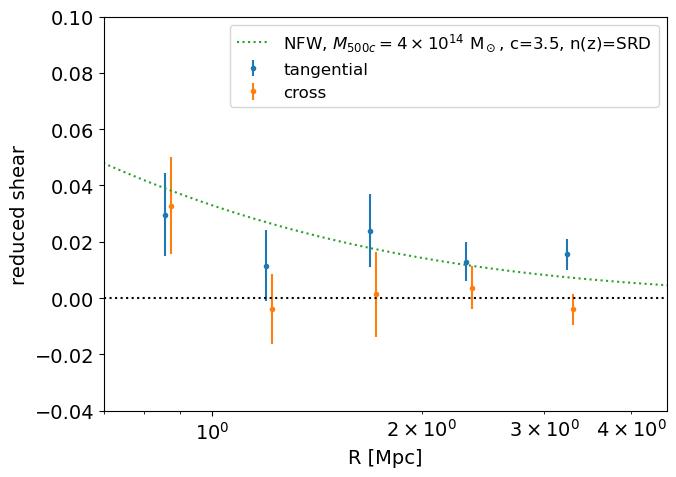

In [70]:
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

ax.errorbar(gc_object_rad.profile['radius'], gc_object_rad.profile['gt'], gc_object_rad.profile['gt_err'], 
             ls='', marker='.', label='tangential')
ax.errorbar(gc_object_rad.profile['radius']*1.02, gc_object_rad.profile['gx'], gc_object_rad.profile['gx_err'], 
             ls='', marker='.', label='cross')
ax.plot(rproj, gt_z, label=r'NFW, $M_{500c}=4 \times 10^{14}$ M$_\odot$, c=3.5, n(z)=SRD', ls=':')

ax.set_xscale('log')
ax.axhline(0.0, color='k', ls=':')
ax.set_ylim([-0.04,0.1])
ax.set_xlim([0.7,4.5])
ax.set_xlabel('R [Mpc]')
ax.set_ylabel('reduced shear')
ax.legend(loc=1, fontsize=12)
fig.tight_layout()
## fig.savefig('image_output/shear_profile-radial.png')

In [71]:
gamma_t = gc_object_rad.profile['gt']
sigma_t = gc_object_rad.profile['gt_err']
gamma_x = gc_object_rad.profile['gx']
sigma_x = gc_object_rad.profile['gx_err']

# Compute chi-squared statistic (compared to null hypothesis)
chi2_stat_t = np.sum((gamma_t / sigma_t)**2)
chi2_stat_x = np.sum((gamma_x / sigma_x)**2)
dof = len(gamma_t)

# Compute p-value from chi-squared distribution
p_value_t = 1 - chi2.cdf(chi2_stat_t, dof)
p_value_x = 1 - chi2.cdf(chi2_stat_x, dof)

# Convert p-value to significance in sigma
significance_sigma_t = norm.isf(p_value_t)  # isf = inverse survival function (1 - CDF)
significance_sigma_x = norm.isf(p_value_x)  # isf = inverse survival function (1 - CDF)

# Print results
print("Tangential signal")
print(f"Chi-squared statistic: {chi2_stat_t:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value_t:.4e}")
print(f"Detection significance: {significance_sigma_t:.2f} sigma")
print("\nCross signal")
print(f"Chi-squared statistic: {chi2_stat_x:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value_x:.4e}")
print(f"Detection significance: {significance_sigma_x:.2f} sigma")

Tangential signal
Chi-squared statistic: 19.382
Degrees of freedom: 5
p-value: 1.6310e-03
Detection significance: 2.94 sigma

Cross signal
Chi-squared statistic: 4.484
Degrees of freedom: 5
p-value: 4.8208e-01
Detection significance: 0.04 sigma


# Validation

## Calculate galaxy density

Originally from https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSM_HSCcalib_CLMM_forTN.ipynb

In [ ]:
gal_density = []
gal_density_err = []
theta_arcmin = []
for i,rbin in enumerate(gc_object1.profile):
    Ngal = gc_object1.profile[i]['n_src']
    rmin = gc_object1.profile[i]['radius_min']
    rmax = gc_object1.profile[i]['radius_max']
    
    theta_min = cosmo.mpc2rad(rmin, 0.22)*180*60/np.pi # arcmin
    theta_max = cosmo.mpc2rad(rmax,0.22)*180*60/np.pi # arcmin
    theta_arcmin.append(cosmo.mpc2rad(gc_object1.profile[i]['radius'],0.22)*180*60/np.pi) # arcmin
#    print(rmin, rmax, theta_arcmin, Ngal, Ngal/(np.pi*(rmax*rmax - rmin*rmin)))    
    print(Ngal)
    gal_density.append(Ngal/(np.pi*(theta_max*theta_max - theta_min*theta_min)))
    gal_density_err.append(np.sqrt(Ngal)/(np.pi*(theta_max*theta_max - theta_min*theta_min)))

plt.errorbar(gc_object1.profile['radius'], gal_density, gal_density_err, ls='', marker='.')
plt.xscale('log')
plt.ylabel(r'$n_{\rm gal}$ [arcmin$^{-2}$]')
plt.xlabel(r'$R$ [Mpc]')

## Check g1/g2 and PSF ellipticities

Check that the PSF and object ellipticities average to ~0

In [ ]:
# print mean values
print("Mean of psfrec_g_1: ", shear_table_wl_ns['psfrec_g_1'].median())
print("Mean of psfrec_g_2: ", shear_table_wl_ns['psfrec_g_2'].median())
print("Mean of wmom_g_1: ", shear_table_wl_ns[f'{meas_type}_g_1'].median())
print("Mean of wmom_g_2: ", shear_table_wl_ns[f'{meas_type}_g_2'].median())

In [ ]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table_wl_ns['psfrec_g_1'], bins=n_bins)
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table_wl_ns['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[2].hist(shear_table_wl_ns[f'{meas_type}_g_1'], bins=n_bins)
axs[2].set_title(f'{meas_type}_g_1')
axs[3].hist(shear_table_wl_ns[f'{meas_type}_g_2'], bins=n_bins)
axs[3].set_title(f'{meas_type}_g_2')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

In [ ]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table_wl_ns['psfrec_g_1'], bins=n_bins)
axs[0].set_yscale('log')
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table_wl_ns['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[1].set_yscale('log')
axs[2].hist(shear_table_wl_ns[f'{meas_type}_g_1'], bins=n_bins)
axs[2].set_title(f'{meas_type}_g_1')
axs[2].set_yscale('log')
axs[3].hist(shear_table_wl_ns[f'{meas_type}_g_2'], bins=n_bins)
axs[3].set_title(f'{meas_type}_g_2')
axs[3].set_yscale('log')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

## Plot `wmom_T_ratio` vs S/N

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(9,6))

shear_table_rs_cuts_ns = shear_table_rs_cuts[shear_table_rs_cuts['shear_type']=='ns']

before = axes.scatter(np.log10(shear_table_rs_cuts_ns[f'{meas_type}_s2n']), shear_table_rs_cuts_ns[f'{meas_type}_T_ratio'], c = shear_table_rs_cuts_ns[f'{meas_type}_T_err'],
           marker='.', s=3, alpha=point_alpha, label="All", cmap='Greens_r')
after = axes.scatter(np.log10(shear_table_wl_ns[f'{meas_type}_s2n']), shear_table_wl_ns[f'{meas_type}_T_ratio'], c = shear_table_wl_ns[f'{meas_type}_T_err'],
           marker='.', s=3, alpha=point_alpha, label='Remaining', cmap='Oranges_r')

bar1 = plt.colorbar(before)
bar2 = plt.colorbar(after)

axes.set_xlabel('$log_{10}$(S/N)')
axes.set_ylabel(f'{meas_type}_T_ratio')
axes.hlines(1.1, 0.5, 5, color='red', label='1.1 limit')
plt.legend()

plt.savefig(f'image_outputs_{meas_type}/obj_T_vs_s2n_err_color.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(7,6))

shear_table_rs_cuts_ns = shear_table_rs_cuts[shear_table_rs_cuts['shear_type']=='ns']

axes.scatter(np.log10(shear_table_rs_cuts_ns[f'{meas_type}_s2n']), shear_table_rs_cuts_ns[f'{meas_type}_T_ratio'], 
           marker='.', s=3, alpha=point_alpha, label="All")
axes.scatter(np.log10(shear_table_wl_ns[f'{meas_type}_s2n']), shear_table_wl_ns[f'{meas_type}_T_ratio'], 
           marker='.', s=3, alpha=point_alpha, label='Remaining')
axes.set_xlabel('$log_{10}$(S/N)')
axes.set_ylabel(f'{meas_type}_T_ratio')
if meas_type == 'wmom':
    axes.hlines(1.1, 0.5, 5, color='red', label='1.1 limit')
elif meas_type == 'gauss':
    axes.hlines(0.3, 0.5, 5, color='red', label='0.3 limit')
elif meas_type == 'pgauss':
    axes.hlines(0.3, 0.5, 5, color='red', label='0.3 limit')
else:
    print("Not an available measurement type")
plt.legend()

plt.savefig(f'image_outputs_{meas_type}/obj_T_vs_s2n.png', bbox_inches='tight')
plt.show()

## Plot object density as a function of every cut

In [52]:
obj_density = shear_table_rs_cuts.copy()
obj_density = obj_density[obj_density['shear_type']=='ns']

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(19,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

axes[0].scatter(shear_table_dup['ra'][shear_table_dup['shear_type']=='ns'], shear_table_dup['dec'][shear_table_dup['shear_type']=='ns'], marker='.', s=0.1, alpha=0.6) 
axes[0].set_title("No cuts")
axes[0].set_xlabel("ra")
axes[0].set_ylabel("dec")
axes[0].invert_xaxis()

axes[1].scatter(obj_density['ra'], obj_density['dec'], marker='.', s=0.1, alpha=0.6) 
axes[1].set_title("Duplicate and Red Sequence Cuts")
axes[1].set_xlabel("ra")
axes[1].invert_xaxis()

axes[2].scatter(shear_table_wl_ns['ra'], shear_table_wl_ns['dec'], marker='.', s=0.1, alpha=0.6) 
axes[2].set_title("All cuts")
axes[2].set_xlabel("ra")
axes[2].set_xlim(ra_bcg-0.7, ra_bcg+0.7)
axes[2].set_ylim(dec_bcg-0.7, dec_bcg+0.7)
axes[2].invert_xaxis()

for ax in axes.reshape(-1):
    ax.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')

plt.suptitle("Object Distribution", size=16, y=0.98)
plt.savefig(f'image_outputs_{meas_type}/object-distribution-before-after.png', bbox_inches='tight')
plt.show()

In [59]:
obj_density_s2n = obj_density[obj_density[f'{meas_type}_s2n']>10]
obj_density_t = obj_density[obj_density[f'{meas_type}_T']<20]
obj_density_mfrac = obj_density[obj_density['mfrac']<0.1]
obj_density_gr = obj_density[(obj_density[f'{meas_type}_color_mag_g-r']).abs()<5]
obj_density_ri = obj_density[(obj_density[f'{meas_type}_color_mag_r-i']).abs()<5]
obj_density_gi = obj_density[(obj_density[f'{meas_type}_color_mag_g-i']).abs()<5]
obj_density_bright = obj_density[obj_density[f'{meas_type}_band_mag_i']>20.0]

# apply masks
star_mask = ~mask_hsp['bo'].get_values_pos(obj_density['ra'], obj_density['dec'], lonlat=True) # bright objects
dust_mask = ~mask_hsp['sfd'].get_values_pos(obj_density['ra'], obj_density['dec'], lonlat=True) # masks from SFD dust map
hand_mask = ~mask_hsp['hand'].get_values_pos(obj_density['ra'], obj_density['dec'], lonlat=True)  # masks done by hand, e.g. galactic cirrus
obj_mask = star_mask & dust_mask & hand_mask
obj_density_masks = obj_density[obj_mask]
 
if meas_type == 'wmom':
    obj_density_t_ratio = obj_density[obj_density[f'{meas_type}_T_ratio']>1.1]
    obj_density_imag = obj_density[obj_density[f'{meas_type}_band_mag_i']<24.0]
elif meas_type == 'gauss':
    obj_density_t_ratio = obj_density[obj_density[f'{meas_type}_T_ratio']>0.3]
    obj_density_imag = obj_density[obj_density[f'{meas_type}_band_mag_i']<23.5]
elif meas_type == 'pgauss':
    obj_density_t_ratio = obj_density[obj_density[f'{meas_type}_T_ratio']>0.3]
    obj_density_imag = obj_density[obj_density[f'{meas_type}_band_mag_i']<23.75]
else:
    print("Not an available measurement type")

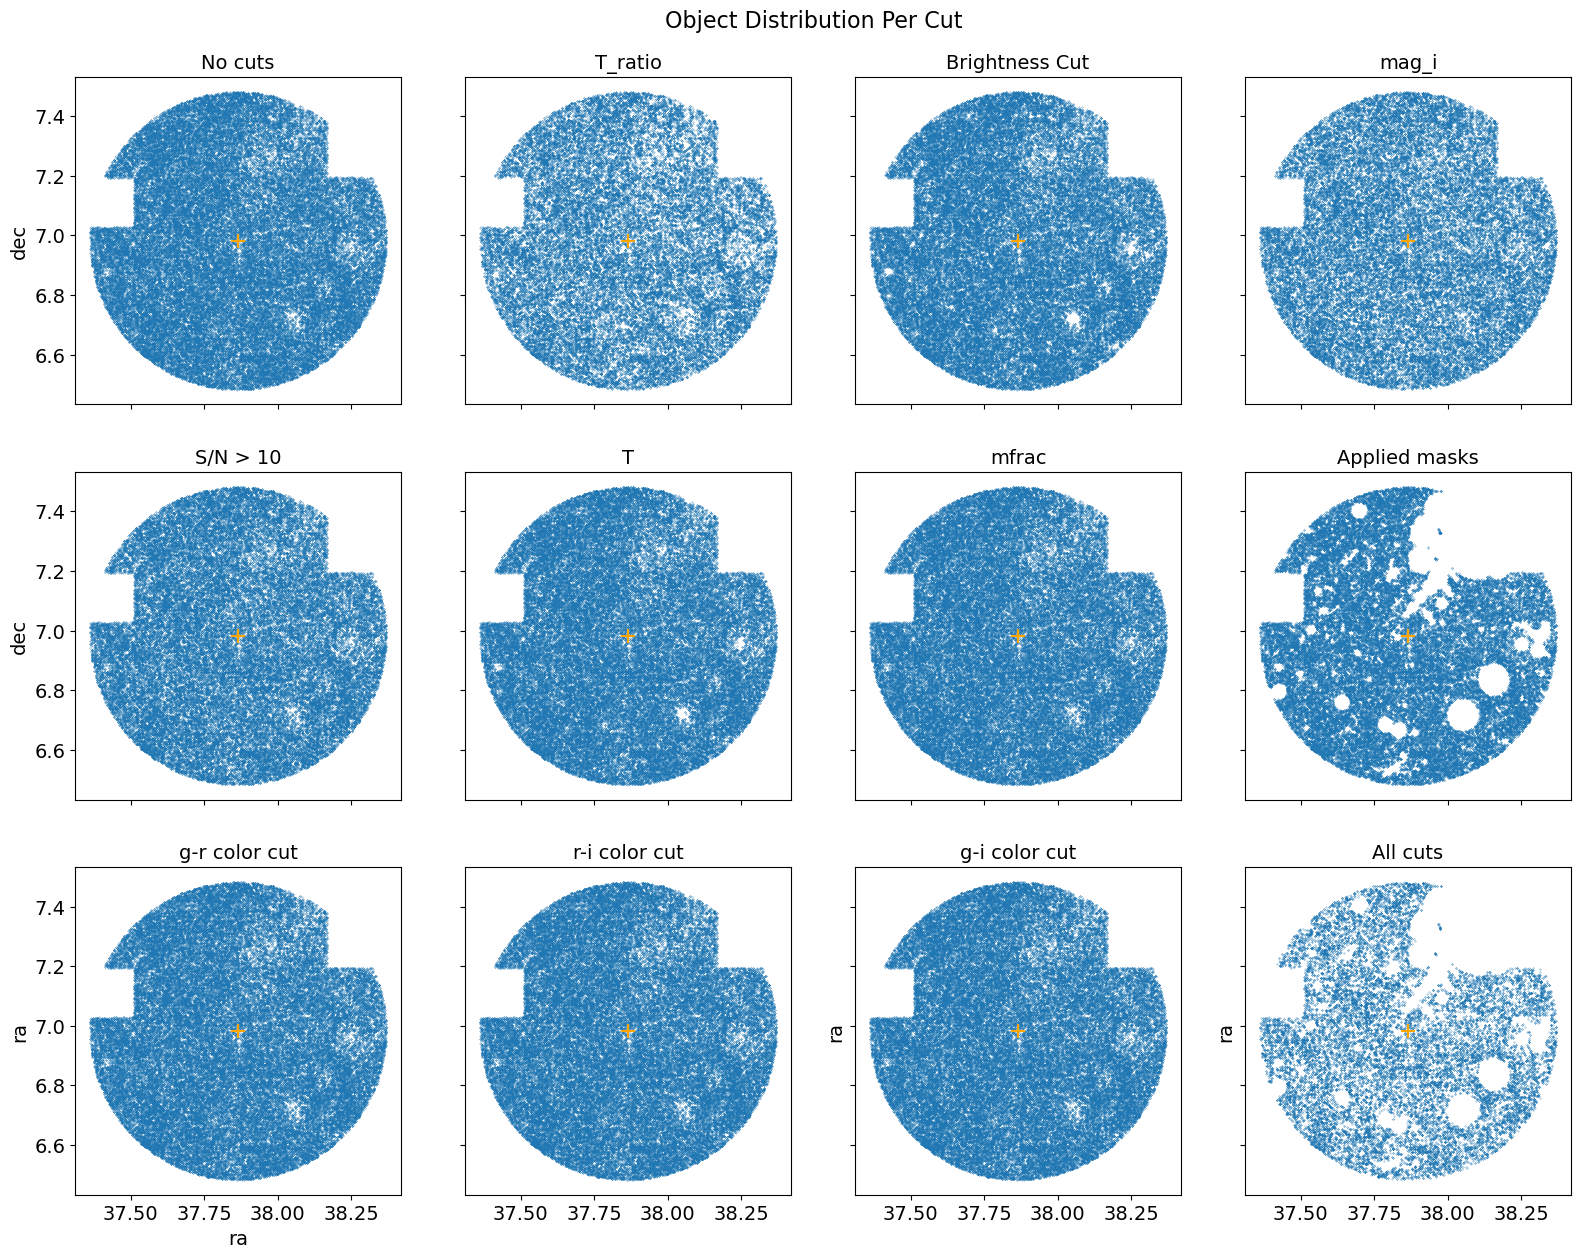

In [61]:
fig, axes = plt.subplots(3,4, figsize=(16,13), sharex=True, sharey=True)
fig.tight_layout(h_pad=2.5, rect=[0, 0.03, 1, 0.95])

axes[0][0].scatter(obj_density['ra'], obj_density['dec'], marker='.', s=0.2) 
axes[0][0].set_title("No cuts")
axes[0][0].set_ylabel("dec")

axes[0][1].scatter(obj_density_t_ratio['ra'], obj_density_t_ratio['dec'], marker='.', s=0.2) 
axes[0][1].set_title("T_ratio")

axes[0][2].scatter(obj_density_bright['ra'], obj_density_bright['dec'], marker='.', s=0.2) 
axes[0][2].set_title("Brightness Cut")

axes[0][3].scatter(obj_density_imag['ra'], obj_density_imag['dec'], marker='.', s=0.2) 
axes[0][3].set_title("mag_i")

axes[1][0].scatter(obj_density_s2n['ra'], obj_density_s2n['dec'], marker='.', s=0.2) 
axes[1][0].set_title("S/N > 10")
axes[1][0].set_ylabel("dec")

axes[1][1].scatter(obj_density_t['ra'], obj_density_t['dec'], marker='.', s=0.2) 
axes[1][1].set_title("T")

axes[1][2].scatter(obj_density_mfrac['ra'], obj_density_mfrac['dec'], marker='.', s=0.2) 
axes[1][2].set_title("mfrac")

axes[1][3].scatter(obj_density_masks['ra'], obj_density_masks['dec'], marker='.', s=0.2) 
axes[1][3].set_title("Applied masks")

axes[2][0].scatter(obj_density_gr['ra'], obj_density_gr['dec'], marker='.', s=0.2) 
axes[2][0].set_title("g-r color cut")
axes[2][0].set_ylabel("dec")
axes[2][0].set_xlabel("ra")

axes[2][1].scatter(obj_density_ri['ra'], obj_density_ri['dec'], marker='.', s=0.2) 
axes[2][1].set_title("r-i color cut")
axes[2][0].set_ylabel("ra")

axes[2][2].scatter(obj_density_gi['ra'], obj_density_gi['dec'], marker='.', s=0.2) 
axes[2][2].set_title("g-i color cut")
axes[2][2].set_ylabel("ra")

axes[2][3].scatter(shear_table_wl_ns['ra'], shear_table_wl_ns['dec'], marker='.', s=0.2) 
axes[2][3].set_title("All cuts")
axes[2][3].set_ylabel("ra")

for ax in axes.reshape(-1):
    ax.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')

plt.suptitle("Object Distribution Per Cut", size=16, y=0.98)
plt.savefig(f'image_outputs_{meas_type}/object-distribution-cuts.png', bbox_inches='tight')
plt.show()

## Plot distribution of cell properties in A360 region

Each run of the `get_cell_inputs` function should only take 3-4 minutes. If it's longer, try again later.

In [ ]:
from lsst.sphgeom import Box, HealpixPixelization
import healpy as hp
from hpgeom import hpgeom
import skyproj

# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

# define healpix parameters
nside_coverage = 2**8
nside_sparse = 2**14

pixelization = HealpixPixelization(hp.nside2order(nside_sparse))

In [ ]:
# method find the pixel indices that overlap the sky projection of the cell area
def get_cell_pixels(cell, wcs):
    cell_bbox = cell.inner.bbox
    begin_coord = wcs.pixelToSky(cell_bbox.beginX, cell_bbox.beginY)
    end_coord = wcs.pixelToSky(cell_bbox.endX, cell_bbox.endY)
    
    if begin_coord.getRa() < end_coord.getRa():
        ra1 = begin_coord.getRa().asDegrees()
        ra2 = end_coord.getRa().asDegrees()
    else:
        ra1 = end_coord.getRa().asDegrees()
        ra2 = begin_coord.getRa().asDegrees()
    
    if begin_coord.getDec() < end_coord.getDec():
        dec1 = begin_coord.getDec().asDegrees()
        dec2 = end_coord.getDec().asDegrees()
    else:
        dec1 = end_coord.getDec().asDegrees()
        dec2 = begin_coord.getDec().asDegrees()

    indices = hpgeom.query_box(nside=nside_sparse, a0=ra1, a1=ra2, b0=dec1, b1=dec2)
    
    return indices

In [ ]:
# return PSF e magnitude of the cell
def get_psf_e(cell, wcs):
    # get psf image of cell
    psf_im = cell.psf_image
    
    psf_kernel = afwMath.FixedKernel(psf_im)
    psf = meas.KernelPsf(psf_kernel)
    shape = psf.computeShape(psf_im.getBBox().getCenter())
    
    trace_radius = shape.getTraceRadius()
    i_xx, i_yy, i_xy = shape.getIxx(), shape.getIyy(), shape.getIxy()
    
    q = Quadrupole(i_xx, i_yy, i_xy)
    s = SeparableDistortionTraceRadius(q)
    
    e1, e2 = s.getE1(), s.getE2()
    e = np.sqrt(e1**2 + e2**2)
    
    return e

In [ ]:
# returns the limiting PSF magnitude of each pixel, given the cell object and statistics settings
def get_mag_lim(cell, statsCtrl, zp=31.4, num_sigma=5):
    
    # get psf area of cell
    psf_im = cell.psf_image.array
    numer = np.square(np.sum(psf_im))
    # numer = 1 # I've seen this as well, but said to be prone to changing if stamp size changes
    denom = np.sum(np.square(psf_im))
    psf_area = numer/denom

    # get total cell weight
    accTask = AssembleCellCoaddTask()
    mask_im = cell.inner.asMaskedImage()
    computed_weight = accTask._compute_weight(mask_im, statsCtrl)
    # the computed weight will be the same value for each pixel
    total_weight = computed_weight * mask_im.getDimensions()[0] * mask_im.getDimensions()[1]
    
    maglim = zp-2.5*np.log10(num_sigma*np.sqrt(psf_area/total_weight))
    
    return maglim

In [ ]:
def get_cell_inputs(cell_collection, tract_patch_list, band):

    cell_df = pd.DataFrame()
    cell_ra = []
    cell_dec = []
    pixel_indices = []
    inputs_list = []
    mag_lim_list = []
    psf_e_list = []

    segs = [] # collection of lines to plot patch outlines

    for tract, patch in tract_patch_list:
    
        coadd = butler.get('deepCoaddCell', 
                         collections = cell_collection, 
                         instrument = 'LSSTComCam', 
                         skymap = 'lsst_cells_v1', 
                         tract = tract, 
                         patch = patch,
                         band = band,)
        # define a wcs from the given coadd
        wcs = coadd.wcs

        # get coadd outline
        coadd_corners = coadd.inner_bbox.getCorners()
    
        for index, corner in enumerate(coadd_corners):
            corner_coord_start = wcs.pixelToSky(corner.getX(), corner.getY())
            if index < 3:
                corner_coord_end = wcs.pixelToSky(coadd_corners[index+1].getX(), coadd_corners[index+1].getY())
            else:
                corner_coord_end = wcs.pixelToSky(coadd_corners[0].getX(), coadd_corners[0].getY())
    
            start_ra = corner_coord_start[0].asDegrees()
            start_dec = corner_coord_start[1].asDegrees()
    
            end_ra = corner_coord_end[0].asDegrees()
            end_dec = corner_coord_end[1].asDegrees()
    
            segs.append(((start_ra, start_dec), (end_ra, end_dec)))
        
        cell_list = list(coadd.cells.keys()) # skips indices that are empty

        # for each cell in cell_list:
        for index, cell_index in enumerate(cell_list):
    
            cell = coadd.cells[cell_index]
    
            # get cell coordinates for removing duplicates
            cell_center = cell.inner.bbox.getCenter()
            cell_center_coord = wcs.pixelToSky(cell_center)
            cell_ra.append(cell_center_coord.getRa().asDegrees())
            cell_dec.append(cell_center_coord.getDec().asDegrees())
        
            pixel_indices.append(get_cell_pixels(cell, wcs))
    
            inputs_list.append(cell.visit_count)
            mag_lim_list.append(get_mag_lim(cell, statsCtrl))
            psf_e_list.append(get_psf_e(cell, wcs))
    
        del coadd
        gc.collect()

    cell_df["ra"] = cell_ra
    cell_df["dec"] = cell_dec
    cell_df["pixels"] = pixel_indices
    cell_df["inputs"] = inputs_list
    cell_df["mag_lim"] = mag_lim_list
    cell_df["psf_e"] = psf_e_list

    return cell_df, segs

#### g-band

In [ ]:
cell_df_g, segs_g = get_cell_inputs(cell_collection, tract_patch_list, 'g')

In [ ]:
# remove duplicate cells from overlapping patches
cell_df_g = cell_df_g.drop_duplicates(subset=['ra', 'dec'])

In [ ]:
pixel_df_g = cell_df_g.explode('pixels').reset_index(drop=True)
pixel_df_g = pixel_df_g.drop_duplicates(subset=["pixels"]) 
pixel_df_g = pixel_df_g.dropna(subset=['pixels'])

pixels_g = pixel_df_g["pixels"].to_numpy()
pixel_input_g = pixel_df_g["inputs"].to_numpy()
pixel_mag_lim_g = pixel_df_g["mag_lim"].to_numpy()
pixel_psf_e_g = pixel_df_g["psf_e"].to_numpy()

In [ ]:
hsp_map_input_g = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_g.update_values_pix(np.array(pixels_g, dtype=np.int64), np.array(pixel_input_g))

hsp_map_mag_lim_g = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_mag_lim_g.update_values_pix(np.array(pixels_g, dtype=np.int64), np.array(pixel_mag_lim_g))

hsp_map_psf_e_g = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_psf_e_g.update_values_pix(np.array(pixels_g, dtype=np.int64), np.array(pixel_psf_e_g))

#### r-band

In [ ]:
cell_df_r, segs_r = get_cell_inputs(cell_collection, tract_patch_list, 'r')

In [ ]:
# remove duplicate cells from overlapping patches
cell_df_r = cell_df_r.drop_duplicates(subset=['ra', 'dec'])

In [ ]:
pixel_df_r = cell_df_r.explode('pixels').reset_index(drop=True)
pixel_df_r = pixel_df_r.drop_duplicates(subset=["pixels"]) 
pixel_df_r = pixel_df_r.dropna(subset=['pixels'])

pixels_r = pixel_df_r["pixels"].to_numpy()
pixel_input_r = pixel_df_r["inputs"].to_numpy()
pixel_mag_lim_r = pixel_df_r["mag_lim"].to_numpy()
pixel_psf_e_r = pixel_df_r["psf_e"].to_numpy()

In [ ]:
hsp_map_input_r = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_r.update_values_pix(np.array(pixels_r, dtype=np.int64), np.array(pixel_input_r))

hsp_map_mag_lim_r = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_mag_lim_r.update_values_pix(np.array(pixels_r, dtype=np.int64), np.array(pixel_mag_lim_r))

hsp_map_psf_e_r = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_psf_e_r.update_values_pix(np.array(pixels_r, dtype=np.int64), np.array(pixel_psf_e_r))

#### i-band

In [ ]:
cell_df_i, segs_i = get_cell_inputs(cell_collection, tract_patch_list, 'i')

In [ ]:
# remove duplicate cells from overlapping patches
cell_df_i = cell_df_i.drop_duplicates(subset=['ra', 'dec'])

In [ ]:
pixel_df_i = cell_df_i.explode('pixels').reset_index(drop=True)
pixel_df_i = pixel_df_i.drop_duplicates(subset=["pixels"]) 
pixel_df_i = pixel_df_i.dropna(subset=['pixels'])

pixels_i = pixel_df_i["pixels"].to_numpy()
pixel_input_i = pixel_df_i["inputs"].to_numpy()
pixel_mag_lim_i = pixel_df_i["mag_lim"].to_numpy()
pixel_psf_e_i = pixel_df_i["psf_e"].to_numpy()

In [ ]:
hsp_map_input_i = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_i.update_values_pix(np.array(pixels_i, dtype=np.int64), np.array(pixel_input_i))

hsp_map_mag_lim_i = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_mag_lim_i.update_values_pix(np.array(pixels_i, dtype=np.int64), np.array(pixel_mag_lim_i))

hsp_map_psf_e_i = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_psf_e_i.update_values_pix(np.array(pixels_i, dtype=np.int64), np.array(pixel_psf_e_i))

#### Input Distribution Plot

The three missing patches were due to pipeline failures, though are not included within the 0.5 degree radius of the BCG

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5.3))
sp_g = skyproj.GnomonicSkyproj(ax=ax[0], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_g.draw_hspmap(hsp_map_input_g, vmin=1, vmax=pixel_input_i.max())
sp_g.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_g.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_g.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_g.draw_colorbar(shrink=0.8, label='Number of input warps per cell')
sp_g.ax.set_title("g-band", pad=25)
for seg in segs_g:
    sp_g.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp_r = skyproj.GnomonicSkyproj(ax=ax[1], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_r.draw_hspmap(hsp_map_input_r, vmin=1, vmax=pixel_input_i.max())
sp_r.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_r.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_r.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_r.draw_colorbar(shrink=0.8, label='Number of input warps per cell')
sp_r.ax.set_title("r-band", pad=25)
for seg in segs_r:
    sp_r.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
    
sp_i = skyproj.GnomonicSkyproj(ax=ax[2], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_i.draw_hspmap(hsp_map_input_i, vmin=1, vmax=pixel_input_i.max())
sp_i.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_i.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_i.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_i.draw_colorbar(shrink=0.8, label='Number of input warps per cell')
sp_i.ax.set_title("i-band", pad=25)
for seg in segs_i:
    sp_i.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

plt.suptitle("Input Image Distribution of the A360 Region", size=15)

plt.savefig(f'image_outputs_{meas_type}/3_band_image_distribution.png', bbox_inches='tight')
plt.show()

#### Limiting Magnitude Distribution Plot

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(19.5, 5.5))
sp_g = skyproj.GnomonicSkyproj(ax=ax[0], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_g.draw_hspmap(hsp_map_mag_lim_g)
sp_g.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_g.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_g.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_g.draw_colorbar(shrink=0.9, label='5-sigma Limiting Magnitude')
sp_g.ax.set_title("g-band", pad=25)
for seg in segs_g:
    sp_g.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp_r = skyproj.GnomonicSkyproj(ax=ax[1], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_r.draw_hspmap(hsp_map_mag_lim_r)
sp_r.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_r.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_r.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_r.draw_colorbar(shrink=0.9, label='5-sigma Limiting Magnitude')
sp_r.ax.set_title("r-band", pad=25)
for seg in segs_r:
    sp_r.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
    
sp_i = skyproj.GnomonicSkyproj(ax=ax[2], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_i.draw_hspmap(hsp_map_mag_lim_i)
sp_i.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_i.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_i.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_i.draw_colorbar(shrink=0.9, label='5-sigma Limiting Magnitude')
sp_i.ax.set_title("i-band", pad=25)
for seg in segs_i:
    sp_i.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

plt.suptitle("5-sigma Limiting Magnitude Distribution of the A360 Region", size=15)

plt.savefig(f'image_outputs_{meas_type}/3_band_mag_lim_distribution.png', bbox_inches='tight')
plt.show()

There may be some noise missing in the covariance due to the warping process. These plots should be taken with a grain of salt.

#### PSF Ellipticity Distribution Plot

In [ ]:
# mean PSF ellipticies for each band
print("Mean PSF ellipticity in g-band: ", pixel_psf_e_g.mean())
print("Mean PSF ellipticity in r-band: ", pixel_psf_e_r.mean())
print("Mean PSF ellipticity in i-band: ", pixel_psf_e_i.mean())
print()
# median PSF ellipticies for each band
print("Median PSF ellipticity in g-band: ", np.median(pixel_psf_e_g))
print("Median PSF ellipticity in r-band: ", np.median(pixel_psf_e_r))
print("Median PSF ellipticity in i-band: ", np.median(pixel_psf_e_i))

In [ ]:
# get minimum / maximum PSF ellipticities for a consistent colorbar
print(pixel_psf_e_g.min())
print(pixel_psf_e_r.min())
print(pixel_psf_e_i.min())

print(pixel_psf_e_g.max())
print(pixel_psf_e_r.max())
print(pixel_psf_e_i.max())

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(19.5, 5.5))
sp_g = skyproj.GnomonicSkyproj(ax=ax[0], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_g.draw_hspmap(hsp_map_psf_e_g, vmin=0, vmax=pixel_psf_e_i.max())
sp_g.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_g.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_g.draw_colorbar(shrink=0.9, label='PSF Ellipticity Modulus')
sp_g.ax.set_title("g-band", pad=25)
for seg in segs_g:
    sp_g.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp_r = skyproj.GnomonicSkyproj(ax=ax[1], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_r.draw_hspmap(hsp_map_psf_e_r, vmin=0, vmax=pixel_psf_e_i.max())
sp_r.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_r.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_r.draw_colorbar(shrink=0.9, label='PSF Ellipticity Modulus')
sp_r.ax.set_title("r-band", pad=25)
for seg in segs_r:
    sp_r.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
    
sp_i = skyproj.GnomonicSkyproj(ax=ax[2], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_i.draw_hspmap(hsp_map_psf_e_i, vmin=0, vmax=pixel_psf_e_i.max())
sp_i.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_i.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_i.draw_colorbar(shrink=0.9, label='PSF Ellipticity Modulus')
sp_i.ax.set_title("i-band", pad=25)
for seg in segs_i:
    sp_i.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

plt.suptitle("PSF Ellipticity Distribution of the A360 Region", size=15)

plt.savefig(f'image_outputs_{meas_type}/3_band_psf_e_distribution.png', bbox_inches='tight')
plt.show()

## Investigate Patch Failures

In [64]:
# check if any of the patches from running cell-based coadds failed
for ref in butler.registry.queryDatasets('assembleCellCoadd_log', collections=cell_collection):
    
    # the only parts of these tracts within 0.5 radius overlap with already included patches
    if ref.dataId['tract'] == 10704 or ref.dataId['tract'] == 10705:
        continue

    # these column of patches overlap with patches already in tract 10464
    if ref.dataId['tract'] == 10463 and ref.dataId['patch'] in overlap_patches_10463:
        continue

    patch_log = butler.get('assembleCellCoadd_log', 
                     collections = cell_collection, 
                     instrument = 'LSSTComCam', 
                     skymap = 'lsst_cells_v1', 
                     tract = ref.dataId['tract'], 
                     patch = ref.dataId['patch'],
                     band = 'i')
    
    patch_error = [log['message'] for log in patch_log.model_dump() if log['levelname'] == 'ERROR']
    if len(patch_error) > 0:
        print(patch_error)

In [63]:
# check if any patches running Metadetection have failed and why
for ref in butler.registry.queryDatasets('metadetectionShear_log', collections=collection):
    
    # the only parts of these tracts within 0.5 radius overlap with already included patches
    if ref.dataId['tract'] == 10704 or ref.dataId['tract'] == 10705:
        continue

    # these column of patches overlap with patches already in tract 10464
    if ref.dataId['tract'] == 10463 and ref.dataId['patch'] in overlap_patches_10463:
        continue
        
    patch_log = butler.get('metadetectionShear_log', 
                     collections = collection, 
                     instrument = 'LSSTComCam', 
                     skymap = 'lsst_cells_v1', 
                     tract = ref.dataId['tract'], 
                     patch = ref.dataId['patch'],
                     band = 'i')
    
    patch_error = [log['message'] for log in patch_log.model_dump() if log['levelname'] == 'ERROR']
    if len(patch_error) > 0:
        print(patch_error)

["Execution of task 'metadetectionShear' on quantum {skymap: 'lsst_cells_v1', tract: 10463, patch: 34} failed. Exception ValueError: Single band images did not all have the same bounding box"]
["Execution of task 'metadetectionShear' on quantum {skymap: 'lsst_cells_v1', tract: 10464, patch: 98} failed. Exception ValueError: no variance are finite"]
["Execution of task 'metadetectionShear' on quantum {skymap: 'lsst_cells_v1', tract: 10464, patch: 47} failed. Exception ValueError: Single band images did not all have the same bounding box"]
["Execution of task 'metadetectionShear' on quantum {skymap: 'lsst_cells_v1', tract: 10464, patch: 88} failed. Exception ValueError: no variance are finite"]
["Execution of task 'metadetectionShear' on quantum {skymap: 'lsst_cells_v1', tract: 10463, patch: 74} failed. Exception ValueError: Single band images did not all have the same bounding box"]


## HSM Catalog

HSM catalog after first reading in:  6617268 \
HSM catalog after removing RS:  2814028 \
HSM source galaxy sample:   538272

In [3]:
repo_hsm = '/repo/dp1'
collection_hsm = 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260'
butler_hsm = Butler(repo_hsm, collections=collection_hsm)

datasetType = 'object'
merged_cat = pd.DataFrame()

skymap = butler_hsm.get('skyMap', skymap='lsst_cells_v1')

# Looking for all patches in delta deg region around it
delta = 0.5
center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

ra_range = (ra_min, ra_max)
dec_range = (dec_min, dec_max)
radec = [geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)]

tracts_and_patches = skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})

for tract in tp_dict.keys():
    # the only parts of these tracts within 0.5 radius overlap with already included patches
    if tract == 10704 or tract == 10705:
        continue

    print(f'Loading objects from tract {tract}, patches:{tp_dict[tract]}')
    for patch in tp_dict[tract]:
        # these column of patches overlap with patches already in tract 10464
        if tract == 10463 and patch in overlap_patches_10463:
            continue
            
        dataId = {'tract': tract, 'patch' : patch ,'skymap':'lsst_cells_v1'}
        obj_cat = butler_hsm.get(datasetType, dataId=dataId).to_pandas() # new naming convention, and obj_cat is now an astropy table. 
        # select only used columns
        obj_cat_cut = obj_cat[['objectId', 'coord_ra', 'coord_dec', 'x', 'y', 'refExtendedness',
                               'r_cModelFlux', 'i_cModelFlux', 'r_cModelFluxErr', 'i_cModelFluxErr',
                               'r_cModel_flag', 'i_cModel_flag', 'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2',
                               'i_hsmShapeRegauss_sigma', 'i_hsmShapeRegauss_flag', 'i_iPSF_flag', 'i_blendedness',
                               'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_ixx', 'i_iyy', 'i_ixy']]
        
        # filt = obj_cat_cut['detect_isPrimary']==True
        filt = obj_cat_cut['r_cModel_flag']== False
        filt &= obj_cat_cut['i_cModel_flag']== False
        filt &= obj_cat_cut['r_cModelFlux']>0
        filt &= obj_cat_cut['i_cModelFlux']>0
        filt &= obj_cat_cut['refExtendedness'] > 0.5

        merged_cat = pd.concat([merged_cat, obj_cat_cut[filt]], ignore_index=True)

        del obj_cat, obj_cat_cut
        gc.collect()

Loading objects from tract 10463, patches:[30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94]
Loading objects from tract 10464, patches:[37, 47, 57, 67, 77, 87, 97, 38, 48, 58, 68, 78, 88, 98, 39, 49, 59, 69, 79, 89, 99]


In [4]:
print("HSM catalog after first reading in: ", len(merged_cat))

HSM catalog after first reading in:  6617268


HSM catalog after first reading in:  6617268

In [5]:
# RS removal
import astropy.units as u
from astropy.coordinates import SkyCoord

c1 = SkyCoord(merged_cat['coord_ra'], merged_cat['coord_dec'], unit=u.deg)
c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
sep = c1.separation(c2)

merged_cat = merged_cat.copy()

filt = sep.deg < 0.5 #0.5 # larger field for analysis
merged_cat_wl = merged_cat[filt]

mag_i = -2.50 * np.log10(merged_cat_wl['i_cModelFlux']) + 31.4
mag_r = -2.50 * np.log10(merged_cat_wl['r_cModelFlux']) + 31.4
color = mag_r - mag_i

# Filter defined above applied to the full sample
rs_hi = 0.64 - (0.1/5.) * (mag_r-19)
rs_low = 0.44 - (0.1/5.)* (mag_r-19)

rs_filt = np.logical_and(color>rs_low, color<rs_hi)
rs_filt &= mag_r < 22

merged_cat_wl= merged_cat_wl[~rs_filt]

print("HSM catalog after removing RS: ", len(merged_cat_wl))

HSM catalog after removing RS:  2814028


HSM catalog after RS cuts:  2814028

In [6]:
# Compute again magnitudes, but for the RS-free catalog
mag_i = -2.50 * np.log10(merged_cat_wl['i_cModelFlux']) + 31.4
mag_r = -2.50 * np.log10(merged_cat_wl['r_cModelFlux']) + 31.4

# Filters to keep sources with good-quality measured shape in i band
source_filt = np.sqrt(merged_cat_wl['i_hsmShapeRegauss_e1']**2 + merged_cat_wl['i_hsmShapeRegauss_e2']**2) < 4
source_filt &= merged_cat_wl['i_hsmShapeRegauss_sigma']<= 0.4
source_filt &= merged_cat_wl['i_hsmShapeRegauss_flag'] == 0
source_filt &= merged_cat_wl['i_blendedness'] < 0.42
source_filt &= merged_cat_wl['i_iPSF_flag']==0
source_filt &= (merged_cat_wl['i_cModelFlux']/merged_cat_wl['i_cModelFluxErr'])>= 10 # SNR > 10

# Resolution factor quality cut - according to Mandelbaum (2018) paper:
# "we use the resolution factor R2 which is defined using the traces of the moment matrix of the PSF TP and 
# of the observed (PSF-convolved) galaxy image TI as: R2 = 1- TP/TI"
# Best guess to translate that in terms of ComCam objectTable catalog output...

res = 1 - (merged_cat_wl['i_ixxPSF']+ merged_cat_wl['i_iyyPSF']) / (merged_cat_wl['i_ixx']+ merged_cat_wl['i_iyy'])
source_filt &= res >= 0.3

source_filt &= (mag_i <= 24.5) & (mag_i>19) 

print(f'Source sample size: {np.sum(source_filt)}')

Source sample size: 538272


HSM catalog after weak lensing cuts:  538272

## Look at shear profile with no calibration

In [59]:
# get shape uncertainties from covariance matrix
g1_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_11'])
g2_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_22'])
g_err = np.mean([np.array(g1_err.values), np.array(g2_err.values)], axis=0)

In [60]:
galcat_no_cal = GCData()
galcat_no_cal['ra'] = shear_table_wl_ns['ra']
galcat_no_cal['dec'] = shear_table_wl_ns['dec']
galcat_no_cal['e1'] = shear_table_wl_ns[f'{meas_type}_g_1']
galcat_no_cal['e2'] = shear_table_wl_ns[f'{meas_type}_g_2']
galcat_no_cal['e_err'] = g_err/2 # factor of 2 to convert from g to e
# galcat_no_cal['hsm_weight'] = weight
galcat_no_cal['id'] = np.arange(len(shear_table_wl_ns))
galcat_no_cal['z'] = np.zeros(len(shear_table_wl_ns))
    
cluster_id = "Abell 360"
gc_object_no_cal = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat_no_cal, coordinate_system='euclidean')

gc_object_no_cal.compute_tangential_and_cross_components(add=True);

gc_object_no_cal.compute_galaxy_weights(
        shape_component1="e1",
        shape_component2="e2",
        use_shape_error=True,
        shape_component1_err="e_err",
        shape_component2_err="e_err",
        use_shape_noise=True,
        weight_name="w_ls",
        cosmo=cosmo,
        add=True,
    )

gc_object_no_cal.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=False, gal_ids_in_bins=False);

gc_object_no_cal.save(f'./profile_metadetect_{meas_type}_no_cal')

In [61]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(3.5)
moo.set_mass(4.e14)

z_cl = gc_object_no_cal.z

# source properties
# Wrongly assume sources redshift following a the DESC SRD distribution (pre-coded in CLMM). 
# Just to get something in the ballpark of what to expect

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.1),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

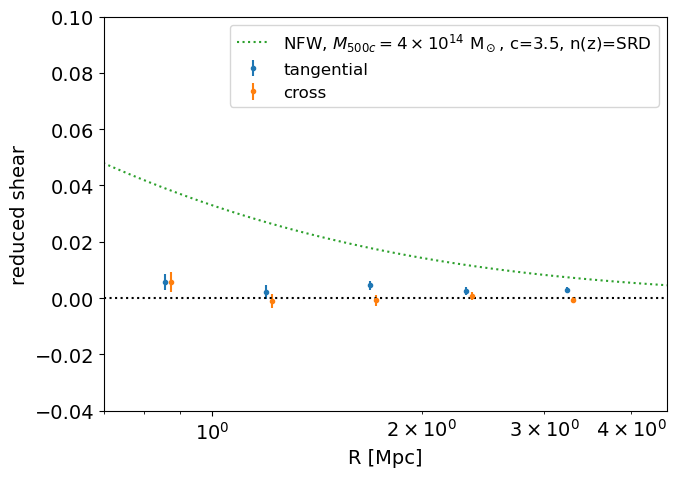

In [62]:
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

ax.errorbar(gc_object_no_cal.profile['radius'], gc_object_no_cal.profile['gt'], gc_object_no_cal.profile['gt_err'], 
             ls='', marker='.', label='tangential')
ax.errorbar(gc_object_no_cal.profile['radius']*1.02, gc_object_no_cal.profile['gx'], gc_object_no_cal.profile['gx_err'], 
             ls='', marker='.', label='cross')
ax.plot(rproj, gt_z, label=r'NFW, $M_{500c}=4 \times 10^{14}$ M$_\odot$, c=3.5, n(z)=SRD', ls=':')

ax.set_xscale('log')
ax.axhline(0.0, color='k', ls=':')
ax.set_ylim([-0.04,0.1])
ax.set_xlim([0.7,4.5])
# ax.set_xlim([0.5,4.5])
ax.set_xlabel('R [Mpc]')
ax.set_ylabel('reduced shear')
ax.legend(loc=1, fontsize=12)
fig.tight_layout()
fig.savefig(f'image_outputs_{meas_type}/shear_profile_no_cal.png')

In [63]:
gamma_t = gc_object_no_cal.profile['gt']
sigma_t = gc_object_no_cal.profile['gt_err']
gamma_x = gc_object_no_cal.profile['gx']
sigma_x = gc_object_no_cal.profile['gx_err']

# Compute chi-squared statistic (compared to null hypothesis)
chi2_stat_t = np.sum((gamma_t / sigma_t)**2)
chi2_stat_x = np.sum((gamma_x / sigma_x)**2)
dof = len(gamma_t)

# Compute p-value from chi-squared distribution
p_value_t = 1 - chi2.cdf(chi2_stat_t, dof)
p_value_x = 1 - chi2.cdf(chi2_stat_x, dof)

# Convert p-value to significance in sigma
significance_sigma_t = norm.isf(p_value_t)  # isf = inverse survival function (1 - CDF)
significance_sigma_x = norm.isf(p_value_x)  # isf = inverse survival function (1 - CDF)

# Print results
print("Tangential signal")
print(f"Chi-squared statistic: {chi2_stat_t:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value_t:.4e}")
print(f"Detection significance: {significance_sigma_t:.2f} sigma")
print("\nCross signal")
print(f"Chi-squared statistic: {chi2_stat_x:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value_x:.4e}")
print(f"Detection significance: {significance_sigma_x:.2f} sigma")

Tangential signal
Chi-squared statistic: 21.662
Degrees of freedom: 5
p-value: 6.0698e-04
Detection significance: 3.24 sigma

Cross signal
Chi-squared statistic: 3.847
Degrees of freedom: 5
p-value: 5.7164e-01
Detection significance: -0.18 sigma
